# RC disc fitting with Selection Function
This notebook demonstrates a use case of modelling the Galactic disc density using Red Clump giants (RC) while accounting for the Selection function. The full methodology is described in detail in Khanna et al. (2024, submitted/arXiv:2410.22036). In this demonstration, we generate a mock catalogue of RC stars, drawn from a simple exponential disc (in R,Z), with a magnitude cut imposed and convolved with an extinction model to mimic an obseverable sample of stars. Then, we generate the appropriate selection function for this sample, and use it to recover the underlying scaling parameters from which the sample was generated. 


## 1. Import packages and create directories

We begin by importing the necessary dependencies that are placed inside the rcdemo subdirectory. We will also create a temporary directory to place data generated in this notebook, and a directory for all figures generated.

In [1]:
initialise_ = True
if initialise_:

	import os, sys
	loc = os.getcwd()
	sys.path.insert(0,loc)	 
	exec(open("./rcdemo/packages_to_import.py").read()) # import external packages
	
	from rcdemo import autil                            # transformations package
	from rcdemo import putil                            # plotting package
	from rcdemo import sutil_sanj                       # histogram package
	from rcdemo import dtools                           # utilities package
	
	
	# set path to temporary directory inside rcdemo
	selfuncdir = loc+'/rcdemo/selfuncdir'; sfdir = selfuncdir+'/sfcylin_2dust_g18'
	tempdir = loc+'/rcdemo/tempdir'
	scratch = loc+'/rcdemo/tempdir/scratch'
	mcmc_res = loc+'/rcdemo/tempdir/mcmc_res'
	figdir = loc+'/rcdemo/figdir'
	# os.system('rm -rf '+tempdir); os.system('mkdir '+tempdir)
	os.system('rm -rf '+scratch); os.system('mkdir '+scratch)
	os.system('rm -rf '+mcmc_res); os.system('mkdir '+mcmc_res)
	os.system('rm -rf '+figdir); os.system('mkdir '+figdir)
	
	
	print('temporary data directory created at:'+str(tempdir))
	print('temporary figure directory created at:'+str(figdir))

    


/Users/shouryapro/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


temporary data directory created at:/Users/shouryapro/Documents/pdoc_work/py_scripts/rcdemo/tempdir
temporary figure directory created at:/Users/shouryapro/Documents/pdoc_work/py_scripts/rcdemo/figdir


## 2. Galactic Model



Next we define the Galactic density model that we wish to simulate. Later we will sample a population of RC stars from this model. For a simple demo, we adopt a disc that is exponential in both the Galactocentric R & Z coordinates. The density $N(R,z)$ is set by the scaling parameters, the scale-length $R_{d}$ and the scale-height $h_{z}$. The disc is flared given by the flare scale-length $R_{fl}$. The inner region of the disc, such as that populated by the Galactic bar can be accounted for using the $R_{cut}$ parameter. Finally, in the more general form we can consider the case where this disc is also warped, i.e., that the midplane is not at the same Z throughout. Together, we get the following expressions, which are included inside the dtools package :

### $N(R,z) \propto exp\left(-\frac{R}{R_{d}} -\frac{R_{cut}}{R} -\frac{|z-z_{w}|}{h_{z}}\right),$
###  $h_{z} = h_{z,\odot}*exp\left(\frac{R - R_{\odot}}{R_{fl}} \right)$
### $ z_{w} = h_{w} \times(R - R_{w})^{a_{w}}  sin(\phi^{'} - \phi_{w})$

We create a function below that will be used later to check if parameter values are within acceptable bounds. We also create a dictionary used to convert parameter names to labels for plotting purpose later.

In [2]:
# function to check for priors
def check_disc_priors(fitparams={},show_=False):
	'''
    checks priors for parameters for the exponential disc model
	'''
	
	minval = {'modscale':1.,
			'modhz':0.05,
			'modrflare':-1.,
			'modinnerCutoffRadius':0.,
			'rd2':1,
			'hz2':0.05,
			'rd3':1,
			'hz3':0.05,
			'fac_rd2':.1,
			'fac_rd3':.1,
			'fac_hz2':0.1,
			'fac_hz3':0.1,
			'fdisc1':0.01,	
			'fdisc2':0.0,	
			'rflare2':-1,
			'fac_rflare2':0.1,
			'phiw':110.,
			'Rw' :4.3 ,
			'aw' : 0.1,
			'hw0' : 0.001,			
			
				}
	maxval = {'modscale':5.5,
			'modhz':2.0,
			'modrflare':3.,
			'modinnerCutoffRadius':10.,
			'rd2':5.5,
			'hz2':2.,			
			'rd3':5.5,
			'hz3':2.,			
			'fac_rd2':3.,
			'fac_rd3':2.,
			'fac_hz2':3,
			'fac_hz3':5,
			'fdisc1':1.,	
			'fdisc2':1.,	
			'rflare2':50,	
			'fac_rflare2':5,	
			'phiw':270. ,
			'Rw' :15.,
			'aw' : 5.,
			'hw0' : 2.5,				
				}
	

	res = True
	if show_ == False:
		
		for inum,param in enumerate(fitparams.keys()):
				
			if param in minval and param in maxval:				
							
				if fitparams[param] >= minval[param] and fitparams[param] <= maxval[param]:
					res= res* True
				
				else:
		
					res = res*False
		
		return res

	elif show_:
		return minval, maxval	



param_nam_col = {'modscale':'$R_{d}$',
			'modhz':r'$h_{z,\odot}$',
			'modrflare':'$log_{10}R_{fl}$',
			'modinnerCutoffRadius':'$R_{in-cut}$',
			'fdisc1':'$f_{d1}$',	
			'fdisc2':'$f_{d2}$',		
			'fdisc3':'$f_{d3}$',								
			'phiw': r'$\phi_{w}$',
			'Rw' : '$R_{w}$',
			'aw' : '$a_{w}$',
			'hw0' : '$h_{w0}$',
			'warpmode':'warp1',
			'warpmode2':'warp2',			
			'rd2':'$R_{d}2$',
			'rd3':'$R_{d}3$',
			'hz2':r'$hz_{2, \odot}$',
			'hz3':r'$hz_{3, \odot}$',
			'rflare2':'$R_{fl2}$',
			'fac_rflare2':'$R_{fl2}/R_{fl1}$'}



## 3. Set globals
It is helpful to define here the values of parameters that will be used globally in this notebook. This is also where the disc model used can be tweaked.

In [3]:
setglobals = True

if setglobals:
	
	lkltype = 'poiss'
	# sfsuffix = '3d'
	sfsuffix = 'test'	
	rat_w1g = 0.07
	ebv2aw1_ = 0.17460714
	ebv2ag_ =  ebv2aw1_/rat_w1g
	xsun = dtools.get_lsr()['xsun']
	absmag_lit = {'absj':-0.93,'absh':-1.46,'absk':-1.61,'absg':0.44,'absw1':-1.68} #literature values of RC absolute magnitude
	sig_absmag_lit = {'absj':0.20,'absh':0.17,'absk':0.17,'absg':0.2,'absw1':0.1}	#literature values of RC absolute magnitude dispersion
	dmod_min, dmod_max = -5.,25.
	
	# disc model globals
	usemaglim = 18 # magnitude limit of the mock survey
	agama_dustmode_2d = True # sample mock using a dust model 
	add_dust_to_grid_2d = True
	agama_gunlim_mode = False # if set to true then this applies the top level GU selection function while sampling stars
	
	Ntot = 1000000 # number of stars to generate 
	
	warpmode = 'off'          # True if include warped disc
	modinnerCutoffRadius = 0. # rcut parameter (0 in the absence of a bar for example)
	Rflare_start =  -xsun
	ncomps = 1 # Number of disc components
	modrflare =  0.6         # log10(Rfl)
	modscale =   3.5         # Rd
	modhz =    0.3           # hz_sun
	
	# warp parameters only applicable if warpmode = 'on'
	phiw = 170               # warp line-of-node lies along this azimuth
	Rw =  6.3                # warp onset radius 
	aw = 1.                  # warp exponent
	hw0 = 0.28               # warp amplitude
	fdisc1 = 1.              # disc mass fraction (set to 1 for ncomps = 1)
	
	discp1 = {'Rflare_start':Rflare_start,
					'modhz': modhz,
					'modscale': modscale,
					'modrflare':modrflare,
					'modinnerCutoffRadius': modinnerCutoffRadius,
					'phiw': phiw,
					'Rw' : Rw,
					'aw' : aw,
					'hw0' : hw0,
					'dmaglim': usemaglim,
					'warpmode':warpmode				
					}
	
	fitparams1_exact = {
				'modscale':discp1['modscale'],
				'modhz':discp1['modhz'],
				'modrflare':discp1['modrflare'],
				'modinnerCutoffRadius':modinnerCutoffRadius,
				'phiw': phiw,
				'Rw' : Rw,
				'aw' : aw,
				'hw0' : hw0,
				'warpmode':warpmode,		
				'fdisc1':fdisc1,}
		
	
	fitparams1 = {}
	for ky in fitparams1_exact.keys():
		minparam,maxparam = check_disc_priors(fitparams=fitparams1_exact.copy(),show_=True)
		if ky in minparam.keys():
			fitparams1[ky] = 0.5*(minparam[ky] + maxparam[ky])
	
	
	import dustmaps.sfd
	sfd = dustmaps.sfd.SFDQuery()
	
	


## 4. Generate RC disc

Let us generate a catalog of mock RC like stars. We assume here, for simplicity, that the absolute magnitude in RC has a Gaussian like distribution, such that $N$(Mg,sigma_Mg). Using this, we can generate an artificial Luminosity function which we will later use to sample RC like stars from:

### a) Luminosity function (LF)

lumfunc_use .pkl written to /Users/shouryapro/Documents/pdoc_work/py_scripts/rcdemo/tempdir


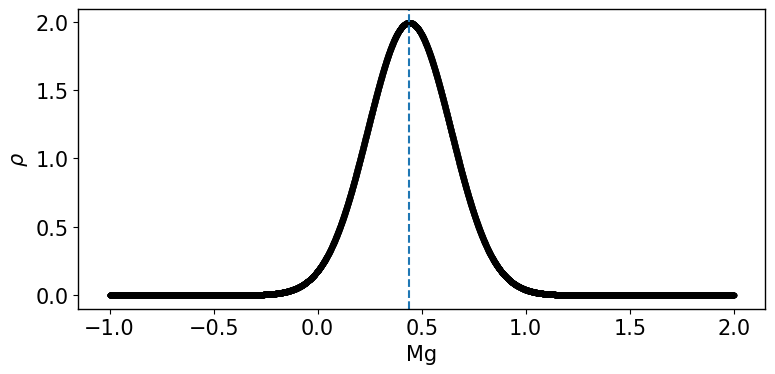

In [4]:
### a) Luminosity function (LF)

prep_lumfunc = True
if prep_lumfunc:

	# Generate RC Luminosity Function
	mgmin,mgmax = -1., 2.
	mg = numpy.linspace(mgmin,mgmax, 10000)
	ye = norm.pdf(mg,loc=absmag_lit['absg'],scale=sig_absmag_lit['absg'])	
	
	zm = interp1d(mg,ye,bounds_error=False,fill_value=(ye[0],ye[-1]))			
	gridM_G = mg
	gridLF = zm(mg)
	gridLF = gridLF
	lumfunc = {}
	lumfunc['gridM_G'] = gridM_G
	lumfunc['gridLF'] = gridLF
	
	# store the luminosity function as a pickle file in tempdir
	dtools.picklewrite(lumfunc,'lumfunc_use',tempdir)
	cdfval,mgmin,mgmax = dtools.pdf2cdf(ye,xv=mg,getlims=True,usesig=2)
	
	# plot LF
	plt.close('all')
	plm=putil.Plm1(1,1,xsize=8.,ysize=4.,xmulti=False,ymulti=False,full=False,slabelx=0.7,slabely=0.07)	
	plm.next()
	plt.plot(mg,ye,'k.')
	plt.axvline(absmag_lit['absg'],linestyle='--')
	plt.xlabel('Mg')
	plt.ylabel(r'$\rho$')
	plm.tight_layout()
	plt.savefig(figdir+'/lfrc.png')



### b) Sample from LF and Galactic model
The function below (samplefnc) reads the LF we prepared above, and is used to sample RC like stars using the Galactic model we adopt.  we call the sampler function in the lines below, where if sampfromlf=True, a mock catalogue is then prepared with the Galactocentric coordinates corrected for the Sun's position. This file is written in tempdir. 

In [5]:
### b) Sample from LF and Galactic model


def samplefnc(data):
	
	lumfunc_use = dtools.pickleread(tempdir+'/lumfunc_use.pkl')
	gridLF,gridM_G = lumfunc_use['gridLF'],lumfunc_use['gridM_G']

	l, sinb, distmod, M_G = data.T
	b = numpy.arcsin(sinb)
	dist = 10**(0.2*distmod-2)		
	binG = numpy.searchsorted(gridM_G, M_G)	
		
	ldeg = np.degrees(l)%360.		
	bdeg = np.degrees(b)		
		
	A_G = 0.
	if agama_dustmode_2d:
		# ebval_ = mydust.getebv(ldeg.astype(float),bdeg.astype(float),dist.astype(float),typ='sfd')		    
		coo  = astropy.coordinates.SkyCoord(l=l * astropy.units.radian, b=b * astropy.units.radian, frame='galactic')
		ebval_ = sfd.query(coo)
		A_G  =  ebval_* ebv2ag_	
	
	# if agama_dustmode_3d:
		# ebval_ = mydust.getebv(ldeg.astype(float),bdeg.astype(float),dist.astype(float),typ='3d',prnt_=False)
		# A_G  =  ebval_* ebv2ag_	
		
	gmag = distmod + M_G + A_G
	jac  = dist**3 * 0.2*numpy.log(10)
	xyz  = numpy.column_stack(agama.getGalactocentricFromGalactic(l, b, dist))
	
	completeness_ = 1
	if agama_gunlim_mode: 	
		# coo  = astropy.coordinates.SkyCoord(l=l * astropy.units.radian, b=b * astropy.units.radian, frame='galactic')
		# completeness_ = dr3sf.query(coo, gmag)	
		# completeness_,unc_vals = gunlim_comp(ldeg,bdeg,gmag,dr3sf,grp=grp,typ='global')
		# completeness_ = np.random.uniform(0.1,1)
		
				
		# # completeness_,unc_vals = gunlim_comp(ldeg,bdeg,gmag,sf,grp=grp,typ='sub')	
		
		# # indnan = dtools.indfinite(completeness_,nans=True,print_=False)
		# # completeness_[indnan] = 0.
		

		completeness_,unc_vals =  simpsf(ldeg,bdeg,gmag,grp)
		
	if ncomps == 1:

		dens1 = dtools.expdisc(xyz,rq=0,zq=0,Rd=discp1['modscale'],hz=discp1['modhz'],mass=fdisc1,innerCutoffRadius=discp1['modinnerCutoffRadius'],
		R0=discp1['Rflare_start'],Rflare_=10.**discp1['modrflare'],phiw=discp1['phiw'],Rw=discp1['Rw'],aw=discp1['aw'],hw0=discp1['hw0'],warp=discp1['warpmode'])

		dens_net = dens1 
	
	
	return  dens_net* jac * gridLF[binG] * completeness_ * (gmag < usemaglim)


# Sample from LF and model, and save data file

sampfromlf = False
if sampfromlf:

	data,mtot = agama.sampleNdim(samplefnc, Ntot, [-np.pi, -1, dmod_min, mgmin], [np.pi, +1, dmod_max, mgmax])[0:2]						
	l, sinb, distmod, M_G = data.T
	b = numpy.arcsin(sinb)		
	dist0 = 10**(0.2*distmod-2)		
	
	ldeg = np.degrees(l)%360.		
	bdeg = np.degrees(b)		
	
	
	if add_rcerrors:
	    # dist_unc = redclumptools.rc_distfunc_interp(dist0,band='g')
	    dist_unc = 0.02*dist0
	    dist=dist0+np.random.normal(size=dist0.size)*dist_unc
	else:
	    dist_unc = np.zeros(dist0.size)
	    dist = dist0.copy()
	
	
	
	xyz = numpy.column_stack(agama.getGalactocentricFromGalactic(l, b, dist, galcen_distance=-xsun,z_sun=0.0))
	coo_mock  = astropy.coordinates.SkyCoord(l=l * astropy.units.radian, b=b * astropy.units.radian, frame='galactic')
	A_G_mock  = np.zeros(l.size) 
	if agama_dustmode_2d:
	    coo  = astropy.coordinates.SkyCoord(l=ldeg * astropy.units.degree, b=bdeg * astropy.units.degree, frame='galactic')
	    ebval_ = sfd.query(coo) 
	    A_G_mock+=  ebval_* ebv2ag_			
		
	
	ag = {}
	ag['pxgc'] = xyz[:,0]
	ag['pygc'] = xyz[:,1]
	ag['pzgc'] = xyz[:,2]
	ag['a_g_mock'] = A_G_mock
	ag['g_mock'] = distmod + M_G + A_G_mock
	# ag['g_mock_true'] = distmod + M_G + A_G_mock
	ag['m_g_mock'] = M_G
	#ag['g_rp'] = np.random.normal(mock_grp['clr'],mock_grp['sig'],distmod.size)
	
	
	dt = ag.copy()
	dt['l0'] = np.degrees(l)%360.
	dt['b0'] = np.degrees(b)
	dt['dist0'] = dist0.copy()
	dt['dist'] = dist.copy()
	dt['dist_unc'] = dist_unc
	dt['rgc'] = np.sqrt(dt['pxgc']**2. + dt['pygc']**2.)
	dt['rgcd'] = np.sqrt(dt['pxgc']**2. + dt['pygc']**2.+ dt['pzgc']**2.)
	
	# save mock file
	mockfname_suff = ''	
	print('saving mock file to '+tempdir)
	dtools.fitswrite(dt,'dmock_agama'+mockfname_suff,tempdir)
	



## Read & Visualise data 
The lines below read in the datafile just prepared, and then we visualise these in Sky & Galactocentric coordinates. The figures generated are saved inside rcdemo, specifically inside the figdir sub-directory.  

In [6]:
# print('44')

# read data
readdata = True

tryloc = tempdir

if readdata:
	
	figformat = 'png'
	fname_use = 'dmock_agama_2d_nw' 
	modversion =  'mock' 
	modversion_ttl_sz = 15
	
	magsuff =''
	

	rgcut_min = 0. #3. # 2
	zcut_min = -20. # -2.
	zcut_max = 20. #2.
	bcut_min = -90. # if -90 then no bcut
	bcut_max = 90. # if +90 then no bcut
	


	if 'dmock_agama' in fname_use:
		

		lkey_use = 'l0'
		bkey_use = 'b0'
		dkey_use = 'dist'
		
		# # res2 = dtools.fitsread(tempdir+'/'+fname_use+'.fits') 		
		res2 = dtools.fitsread(tryloc+'/dmock_agama_2d_nw.fits')
		
		res2['rgcd'+magsuff] = dtools.sqrtsum(ds=[res2['pxgc'+magsuff],res2['pygc'+magsuff],res2['pzgc'+magsuff]])
		res2['rgc'+magsuff] = dtools.sqrtsum(ds=[res2['pxgc'+magsuff],res2['pygc'+magsuff]])

		
		

		res2['g'] = res2['g_mock'].copy()
	
	
	res2['phi1'] = np.degrees(np.arctan2(res2['pygc'+magsuff],res2['pxgc'+magsuff]))%360.
	res2['phiradcells'] = np.degrees(np.arctan(res2['pygc'+magsuff]/-res2['pxgc'+magsuff]))
	

	# compute phi 
	res2['phi'] = res2[lkey_use].copy()
	indg = np.where(res2[lkey_use] < 180)[0]
	res2['phi'][indg] = -(res2[lkey_use][indg]).copy()
	indl = np.where(res2[lkey_use] > 180)[0]
	res2['phi'][indl] = 360. - res2[lkey_use][indl].copy()	
	
	res2['phi2'] = dtools.getphi_(res2[lkey_use],typ='2')			


	if 'rgc'+magsuff not in res2.keys():
		res2['rgc'+magsuff] = np.sqrt(res2['pxgc'+magsuff]**2. + res2['pygc'+magsuff]**2.)		
		res2['rgcd'+magsuff] = np.sqrt(res2['pxgc'+magsuff]**2. + res2['pygc'+magsuff]**2. + res2['pzgc'+magsuff]**2.)		
		

	mydata_ = res2.copy()
	
	print('N before any cuts = '+str(mydata_['rgc'+magsuff].size))	
	dtools.where(mydata_,condition=((mydata_['rgc'+magsuff]>rgcut_min)&(mydata_[bkey_use]>bcut_min)&(mydata_[bkey_use]<bcut_max))
				&(mydata_['pzgc'+magsuff]>zcut_min)&(mydata_['pzgc'+magsuff]<zcut_max)) #for fit
	
	print('N after any cuts = '+str(mydata_['rgc'+magsuff].size))
	print('')



N before any cuts = 1000000
N after any cuts = 998236



#### Visualise data

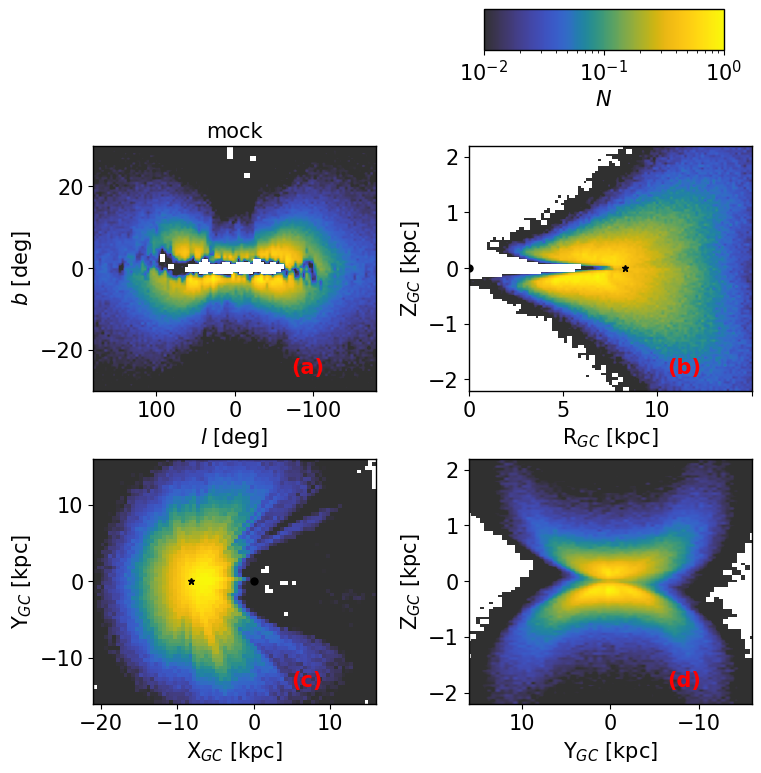

In [7]:
visualise_datamock = True
if visualise_datamock:

	# set plot axis limits
	plot_xmin,plot_xmax = -20, 15
	plot_ymin,plot_ymax = -15, 15
	plot_zmin,plot_zmax = -2.2, 2.2		

	plot_delx = 1.
	plot_dely = 1.
	plot_delz = 0.	
	
	usecmap = 'linear_kbgoy_20_95_c57'		#linear_green_5_95_c69	
	dt = mydata_.copy()
	
	# conds = (dt['phi1'] > 120.)			
	# dtools.where(dt,condition=conds)
	
	
	# sky and xy, xz, rz plots
	plt.close('all')		
	
	lblsize= 15
	fullmode = True

	

	if fullmode:
		# plm=putil.Plm2(2,3,xsize=8.,ysize=6.,xmulti=False,ymulti=False,full=True,slabelx=0.7,slabely=0.07)	
		plm=putil.Plm2(2,2,xsize=8.,ysize=8.,xmulti=False,ymulti=False,full=False,slabelx=0.7,slabely=0.07)	
	


	plm.next(slabclr='red')
	plt.title(modversion,fontsize=modversion_ttl_sz)
	

	# sutil_sanj.hist2d(dt[lkey_use],dt[bkey_use],range=[[0.,360.],[-30.,30.]],bins=100,dnorm=2,norm=LogNorm(vmin=1e-2,vmax=1),cmap=cc.cm['linear_green_5_95_c69'])		
	sutil_sanj.hist2d(dt['phi2'],dt[bkey_use],range=[[-180.,180.],[-30.,30.]],bins=100,dnorm=2,norm=LogNorm(vmin=1e-2,vmax=1),cmap=cc.cm[usecmap])		



	plt.xlabel('$l$ [deg] ')		
	plt.ylabel('$b$ [deg]')		
	if fullmode:

		plt.xlabel('$l$ [deg] ',fontsize=lblsize)		
		plt.ylabel('$b$ [deg]',fontsize=lblsize)							


	plt.xlim([180.,-180.])			
	

	plm.next(slabclr='red')
	
	
	sutil_sanj.hist2d(dt['rgc'+magsuff],dt['pzgc'+magsuff],range=[[0,15.],[plot_zmin,plot_zmax]],bins=100,dnorm=2,norm=LogNorm(vmin=1e-2,vmax=1),cmap=cc.cm[usecmap])		

	plt.plot(-xsun,0.,marker='*',markersize=5,color='black')	
	plt.plot(0.,0.,marker='o',markersize=5,color='black')		

	plt.xlabel('R$_{GC}$ [kpc]')		
	plt.ylabel('Z$_{GC}$ [kpc]')		



	if fullmode:
		plt.xlabel('R$_{GC}$ [kpc]',fontsize=lblsize)		
		plt.ylabel('Z$_{GC}$ [kpc]',fontsize=lblsize)		

	plt.ylim([plot_zmin - plot_delz,plot_zmax + plot_delz])			


	# # if want to include xy
	plm.next(slabclr='red')
	
	sutil_sanj.hist2d(dt['pxgc'+magsuff],dt['pygc'+magsuff],range=[[-25.,25.],[-25.,25.]],bins=100,dnorm=2,norm=LogNorm(vmin=1e-2,vmax=1),cmap=cc.cm[usecmap])		#linear_green_5_95_c69

	# plt.axhline(metadata_['rmin1'],linestyle='--')
	# plt.axvline(metadata_['rmin1'],linestyle='--')
	
	plt.plot(xsun,0.,marker='*',markersize=5,color='black')	
	plt.plot(0.,0.,marker='o',markersize=5,color='black')	
	

	
	plt.xlabel('X$_{GC}$ [kpc]')		
	plt.ylabel('Y$_{GC}$ [kpc]')		


	if fullmode:
		plt.xlabel('X$_{GC}$ [kpc]',fontsize=lblsize)		
		plt.ylabel('Y$_{GC}$ [kpc]',fontsize=lblsize)		
	
	plt.xlim([plot_xmin-plot_dely,plot_xmax+plot_delx])
	plt.ylim([plot_ymin-plot_dely,plot_ymax+plot_dely])
		
	
	plm.next(slabclr='red')
	
	
	im1 = sutil_sanj.hist2d(dt['pygc'+magsuff],dt['pzgc'+magsuff],range=[[-25.,25.],[plot_zmin,plot_zmax]],bins=100,dnorm=2,norm=LogNorm(vmin=1e-2,vmax=1),cmap=cc.cm[usecmap])		
	


	plt.xlabel('Y$_{GC}$ [kpc]')		
	plt.ylabel('Z$_{GC}$ [kpc]')		

	if fullmode:	

		plt.xlabel('Y$_{GC}$ [kpc]',fontsize=lblsize)		
		plt.ylabel('Z$_{GC}$ [kpc]',fontsize=lblsize)		

	plt.xlim([plot_ymin-plot_dely,plot_ymax+plot_dely])	
	plt.ylim([plot_zmin - plot_delz,plot_zmax + plot_delz])			
	dtools.invert('x')

	plm.tight_layout()
	
	plt.subplots_adjust(top=0.8)		

	
										
	#######
	fig=plm.fig						
	pos_topx = 0.62
	pos_topy = 0.92 #0.84 for single slice
	cb_width = .3
	cb_height = 0.05						
	cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])											
	plt.colorbar(im1,cax,orientation='horizontal',label='$N$')

	plt.savefig(figdir+'/data_maps_sky_'+modversion+'.'+figformat)	
	
		
	
	del dt



## Grid Data ($R,\phi,Z$)
After a quick visualisation, we will now bin the data in a cylindrical grid. This grid will first be used to compute the selection function, and then also to carry out the fitting routine to determine the underlying scale parameters of our mock catalogue.

In [8]:
## Grid Data ($R,\phi,Z$)

gridmode = 'cylin'

if gridmode == 'cylin':

	'''
	this fits the data in the Rphiz galactocentric mode..
	fitncomps = number of components to fit.
	
	'''

	mincounts = 1
		
	Rmin,Rmax = 0,20
	phimin,phimax = 0., 360.
	zmin,zmax = -2., 2.	
	
	hresR = 0.25 ; nbinsR = int((Rmax - Rmin)/hresR)                            # resolution & Nbins in R
	hresphi = 10.; nbinsphi = int((phimax - phimin)/hresphi)                    # resolution & Nbins in phi
	hresz = 0.25; nbinsz = int((zmax - zmin)/hresz)	                            # resolution & Nbins in z 


	h1 = sutil_sanj.hist_nd([mydata_['rgc'+magsuff],mydata_['phi1'],mydata_['pzgc'+magsuff]],bins=[nbinsR,nbinsphi,nbinsz],normed=False,range=[[Rmin,Rmax],[phimin,phimax],[zmin,zmax]])
				
	dthist_use = cylingrid(h1,add_dust_to_grid_2d=add_dust_to_grid_2d)
	dthist_use['gmag_pred'] = autil.dist2dmod(dthist_use['dist']) + absmag_lit['absg']
	
	print('writing grid histogram to '+tempdir)
	dtools.picklewrite(dthist_use,'dthist1_rphiz',tempdir,prnt=False)
	

	volum_elem = dthist_use['rgcv']*dthist_use['drgc']*np.radians(dthist_use['dphi'])*dthist_use['dz']
	compmap0 = dthist_use['dens'].copy(); compmap = compmap0.copy()

	
	metadata_ = {}
	metadata_['facuse'] = h1.data.sum()

	metadata_['mincount'] = mincounts
	print('writing grid metadata  to '+tempdir)
	dtools.picklewrite(metadata_,'dthist1_meta_rphiz',tempdir,prnt=False)		





3D map
2d dust
writing grid histogram to /Users/shouryapro/Documents/pdoc_work/py_scripts/rcdemo/tempdir
writing grid metadata  to /Users/shouryapro/Documents/pdoc_work/py_scripts/rcdemo/tempdir


## Compute Selection Function
The function below computes the selection function over the grid selected above. It would need to be run each time the grid is changed, and/or if the magnitude limit is set to a different value, and/or if an extinction model is used or not. In this demo, as set above in global parameters, we compute the total selection function for RC like stars, for the case where:

:G magnitude limit = 18

:2D dust model is applied

In the subdirectory sfdir, we provide the pre-computed selection function for this case and so leave computesf=False in the lines below. Typically for the resolution of the grid chosen here, this exercise takes about 20 minutes on a 11 core machine (2.5 Ghz).

In [9]:


## Compute Selection Function

computesf = False
if computesf:
	
	# add_dust_to_grid_2d = True
			
	sfbinfac = 4 # factor by which to sub-bin the grid while computing the selection function	
	print('computing sf....')
	dthist_usehier = dthist_use.copy()
	
	val = binhierc_cylin3d(dthist_usehier,h1,nbinsR=nbinsR,nbinsphi=nbinsphi,
							nbinsz=nbinsz,Rmin=Rmin,Rmax=Rmax,phimin=phimin,
							phimax=phimax,zmin=zmin,zmax=zmax,extinct_=True,add_dust_to_grid_2d=add_dust_to_grid_2d,add_dust_to_grid_3d=add_dust_to_grid_3d,
							binfac=sfbinfac,mkplots_=False,compsf=True,dmaglim=usemaglim,gusf=False)
							
						
	dtools.picklewrite(val,'sfhier_'+sfsuffix,sfdir)
	
	
	gridparams = {}
	gridparams['Rmin'] = Rmin
	gridparams['Rmax'] = Rmax
	gridparams['phimin'] = phimin
	gridparams['phimax'] = phimax
	gridparams['zmin'] = zmin			
	gridparams['zmax'] = zmax				
	gridparams['hresR'] = hresR
	gridparams['hresphi'] = hresphi
	gridparams['hresz'] = hresz			
	gridparams['nbinsR'] = nbinsR
	gridparams['nbinsphi'] = nbinsphi
	gridparams['nbinsz'] = nbinsz
	gridparams['dmaglim'] = usemaglim
	
	dtools.picklewrite(gridparams,'gridparams_'+sfsuffix,sfdir)
	



## Visualise Selection Function
In the lines below, we will visualise the computed Selection function on a polar grid (R,azimuth) for three different slices in Z. As mentioned before, all precomputed files are stored in the sfdir subdirectory. We can inspect this folder as below:

In [10]:

dtools.fcount(sfdir)
print(sfdir)
print(sfsuffix)

5 files in total
total 106600
-rw-r--r--  1 shouryapro  _lpoperator   202B Nov 19 15:42 gridparams_3d.pkl
-rw-r--r--  1 shouryapro  _lpoperator   202B Nov 19 15:42 gridparams_test.pkl
-rw-r--r--  1 shouryapro  _lpoperator    47M Nov 19 15:42 sfhier_3d.pkl
-rw-r--r--  1 shouryapro  _lpoperator   1.8M Nov 19 15:42 sfhier_interm.pkl
-rw-r--r--  1 shouryapro  _lpoperator   3.2M Nov 19 15:42 sfhier_test.pkl
/Users/shouryapro/Documents/pdoc_work/py_scripts/rcdemo/selfuncdir/sfcylin_2dust_g18
test


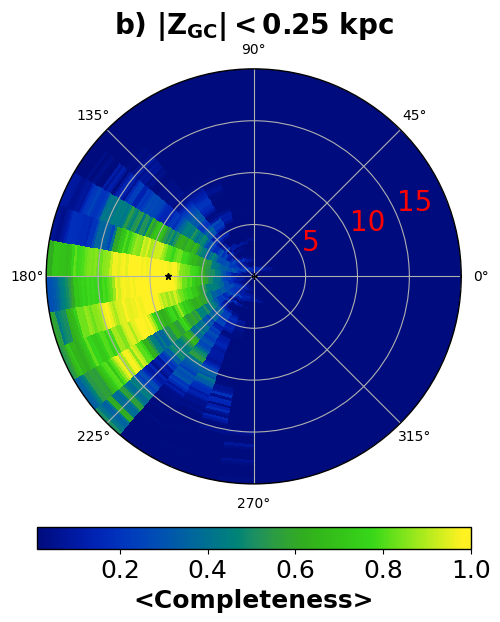

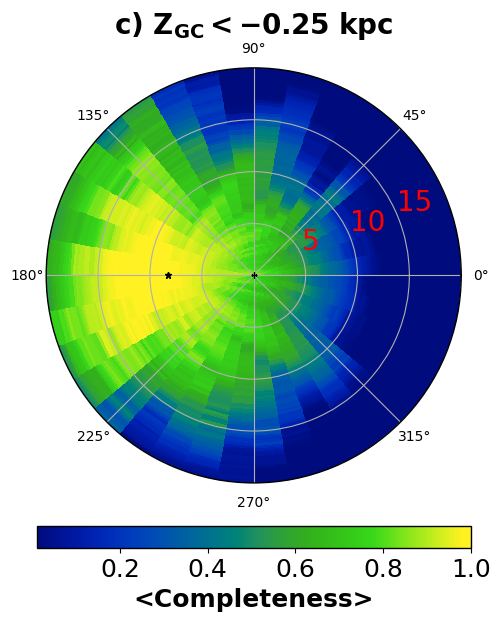

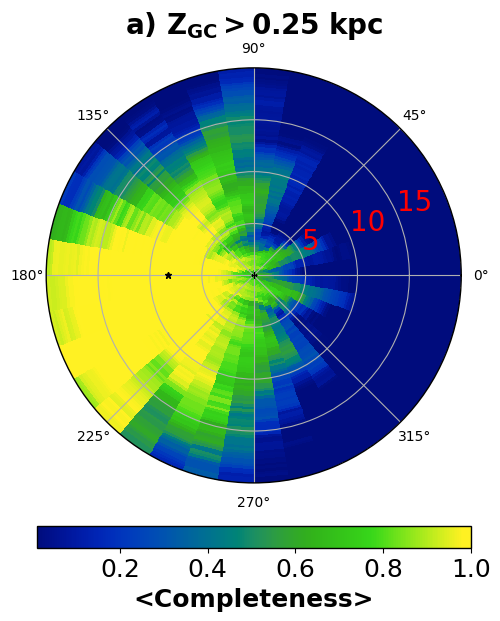

In [11]:
##

visualsf = True

if visualsf:
	
	indvis_comp = np.where((dthist_use['rgc']>3))[0]
	
	usemincount = 10
	
	sfcomp = dtools.pickleread(sfdir+'/sfhier_'+sfsuffix+'.pkl')
	

	# completeness map (polar)

	cmapuse = 'bgy'
	
	
	zcell_min = [-0.25,-3.,0.25]
	zcell_max = [0.25,-0.25,3.]
	# ztxt = ['|z|<0.25 kpc','z < 0.25 kpc','z > 0.25 kpc']
	ztxt = [r'$\bf{|Z_{GC}|<0.25}$ kpc',r'$\bf{Z_{GC} < -0.25}$ kpc',r'$\bf{Z_{GC} > 0.25}$ kpc']
	zlab = ['b','c','a']

	
	delrwarps = 50
	Rwarps = 6
	vmin = 1e-2
	vmax = 1; plt.close('all')
	for i in range(len(zcell_min)):
		parampack = {}
		parampack['zcell_min'] = zcell_min[i]
		parampack['zcell_max'] = zcell_max[i]
		parampack['hresz'] = hresz
		parampack['usemincount'] = False

		im1,h2 =densproj_(sfcomp['sf']*sfcomp['subsf_avg'],cnt=False,typ='Rphi',cmap=cmapuse,normtyp='lognorm',cbar=False,
							lblsuff='completeness',delrwarps=delrwarps,binargs=[nbinsR,nbinsphi,nbinsz,Rmin,Rmax,
							phimin,phimax,zmin,zmax],Rwarps=Rwarps,return_avgcounts=True,vmin=vmin,vmax=vmax,parampack=parampack)	

		azm, rval = np.meshgrid(h2.locations[1],h2.locations[0])
		azm = np.radians(azm)
		
		
		
		fig, ax = plt.subplots(figsize=(8,7),subplot_kw=dict(projection="polar"))
		
		val = np.reshape(h2.data,(azm.shape))
		
		pc = ax.pcolormesh(azm,rval,val, cmap=cc.cm[cmapuse],vmin=vmin,vmax=vmax,shading='nearest')
		pc.axes.tick_params(axis='x', which='major', labelsize=10)
		pc.axes.tick_params(axis='y', which='major', labelsize=10)
		# ax.set_rticks([3., 11.,15.])
		ax.set_rticks([5.,10.,15.])
		# ax.set_rticks([3., 9., 15.])
		# ax.text(0.1,0.1,zlab[i],transform=ax.transAxes,color='black',weight='bold')

		
		rlabels = ax.get_ymajorticklabels()
		for label in rlabels:
		    label.set_color('red')
		    label.set_size(fontsize=20)
		
		
		plt.plot(np.radians(180.),-xsun,marker='*',markersize=5,color='black')	
		plt.plot(0.,0.,marker='+',markersize=5,color='black')	

		# ax.set_xlim([np.radians(-20),np.radians(360)])	
		ax.set_ylim([0,20])
		ax.set_rorigin(0)
		ax.grid(True)
			
		# cb = fig.colorbar(pc,orientation='horizontal',extend='max',shrink=0.7,pad=0.08)
		cb = fig.colorbar(pc,orientation='horizontal',shrink=0.7,pad=0.08)
		cb.set_label(label='<Completeness>',size=18,weight='bold')
		cb.ax.tick_params(axis='y', which='major', labelsize=18)
		cb.ax.tick_params(axis='x', which='major', labelsize=18)
			
				
		plt.title(zlab[i]+') '+ztxt[i],fontsize=20,weight='bold')	
		plt.savefig(figdir+'/completeness_polar_'+str(i)+'.png')

## Fit using Selection Function

Having constructed the selection function, we will now fit our model to mock data.

In [12]:
##


def getmodcount(modtyp,dthist1,params,ncomps=1):

	
	'''
    Purpose: This function returns the predicted number counts from the model
    
    modtyp = 'expdisc'
    dthist1 = 3D histogram object with the data 
    params = dictionary containing model parameters
    ncomps = Number of disc components

	'''

	if modtyp == 'expdisc':
		xyz_my = np.column_stack((dthist1['xv'],dthist1['yv'],dthist1['zv']))

		

		if ncomps < 2:
			val03d_1,val3d_1=dtools.expdisc(xyz_my,innerCutoffRadius=params['modinnerCutoffRadius'],Rd=params['modscale'],
			mass=1.,hz=params['modhz'],R0=Rflare_start,Rflare_=10.**(params['modrflare']),return_surfdens=True,
			phiw=params['phiw'],Rw=params['Rw'],aw=params['aw'],hw0=params['hw0'],warp=params['warpmode'])

			return val03d_1,val3d_1




In [21]:

def myfitdata_mle_warp(theta,printvalmode=False,vmin=1e+1,vmax=1e+05):
# def myfitdata_mle_warp(theta,printvalmode=False,vmin=1e-1,vmax=1e+03):

	'''
	# def myfitdata_mle_warp(theta,ncomps,plot_counts=False,inc_projection=False,apply_dust=False,lkltype='poiss',printvalmode=False,vmin=1e+0,vmax=1e+05):
	'''
		
	plot_innerdisc = True
	
	plot_outerdisc = True
	plot_entirerdisc = True
	
	plot_entirerdisc_z = False
	plot_polar = False

	
	plot_outerdisc_warp_appendix = False
	
	
	plot_surfdens = True
	plot_vertprof = False
	
	funcargs = dtools.pickleread(tempdir+'/funcargs.pkl')
	
	# setup arguments
	residual_wrt_model = funcargs['residual_wrt_model']
	residual_wrt_data = funcargs['residual_wrt_data']
	plot_counts = funcargs['plot_counts']
	inc_projection = funcargs['inc_projection']
	apply_dust = funcargs['apply_dust']
	lkltype = funcargs['lkltype']
	fitncomps = funcargs['fitncomps']
	listparams = funcargs['paramlist']
	listparams_all = funcargs['paramlist_all']
	suffmcmc = funcargs['suffmcmc']
	

	sfsuffix = funcargs['corrsf_typ'].split('_')[1]	

	

	if printvalmode:
		print('trying..')
		print(theta)
		print('fitncomps...')
		print(fitncomps)
		print('lkltype == '+lkltype)
		print('--------------')

	params = {}
	params['modinnerCutoffRadius'] = fitparams1_exact['modinnerCutoffRadius']	
	params['warpmode'] = fitparams1_exact['warpmode']


	
	for i in range(len(theta)):
		params[listparams[i] ] = theta[i]		
	indlx,indrx,indnmx = dtools.crossmatch(np.array(list(params.keys())),np.array(listparams_all))
	includekys = list(np.array(listparams_all)[indnmx])
	for ky in includekys:
		params[ky] = fitparams1_exact[ky]



	# # print(params)
	
	dthist_use = dtools.pickleread(tempdir+'/dthist1_rphiz.pkl')
	metadata_ = dtools.pickleread(tempdir+'/dthist1_meta_rphiz.pkl')		
	facuse = metadata_['facuse']	
	mincount = metadata_['mincount']	
	
	compmap = dthist_use['dens'].copy()
	

	# model section
	modtyp = 'expdisc'	
	val03d, val3d = getmodcount(modtyp,dthist_use,params,ncomps=fitncomps)

	volum_elem = dthist_use['rgcv']*dthist_use['drgc']*np.radians(dthist_use['dphi'])*dthist_use['dz']
		
	modcount3d = (val03d)*volum_elem
	

	#---------------------------------------------------------------
	# restricting to maglim bins for RC
	A_G_grid  = 0.
	if apply_dust:
		A_G_grid  = dthist_use['a_g_val']




	#---working here

	if funcargs['sfmaglim']:

		# # apply dmaglim correction
		if funcargs['corrsf_typ'] == 'dmax':
			

			dmaxs = autil.dmod2dist(dmaglim - A_G_grid - 0.44)									
			ind_gr_dmax = np.where((dthist_use['dist'] > dmaxs))[0]				
			
			print(ind_gr_dmax.size)
			modcount3d[ind_gr_dmax] = 0.	
		elif 'hier' in funcargs['corrsf_typ'] :	
		
			sfcomp = dtools.pickleread(sfdir+'/sfhier_'+sfsuffix+'.pkl')	
	
			# modcount3d = modcount3d*sfcomp['sfval_wrong']
			modcount3d = modcount3d*sfcomp['sf']			

	if funcargs['sfgu']:
		
		
		# # apply gu sf correction


			sfcomp = dtools.pickleread(sfdir+'/sfhier_'+sfsuffix+'.pkl')	
	
			modcount3d = modcount3d*sfcomp['subsf_avg']		
		
	
	
	# Normalisation: correcting for limited volume in grid.
	
	indt1 = np.where(dthist_use['rgcv']<funcargs['rgcut_min'])[0]
	corrfac2 = (np.nansum(modcount3d[indt1]))
	corrfac = (np.nansum(modcount3d))

	tstfac = (facuse/(corrfac - corrfac2))
	modcount3d = (modcount3d*tstfac)
	
	
	#------------------------------------------------------------------------------------------

	
	induse_fit = np.where((compmap > 0.)&(compmap>mincount))[0]			
	
	lkl_prior = np.log(check_disc_priors(params))
	
	
	lkl2 = 0
	


	if inc_projection == False:	
		

	

		tmplkl = dtools.getlikelihood(modcount3d[induse_fit],compmap[induse_fit],typ=lkltype)
		# tmplkl = dtools.getlikelihood((modcount3d[induse_fit]*fbin[induse_fit]).astype(int),(compmap[induse_fit]*fbin[induse_fit]).astype(int),typ=lkltype)
		indok = dtools.indfinite(tmplkl,print_=False)			
		lkl2+=  np.nansum(tmplkl[indok])			
	
		toret = lkl_prior + lkl2


	
	if inc_projection:
		
		# zmin,zmax = -1.8,1.8 
		zmin,zmax = -2.,2.
		
		phimin_,phimax_ = 90,270
	
		if plot_counts:
						

			
			if plot_polar:
				#--- checking polar plot
				
				delrwarps = 50 
				Rwarps = 6.
	
	
				
				zcell_min = [-0.25,-1.,0.25,-1]
				zcell_max = [0.25,-0.25,1.,1]
				# ztxt = [r'$|Z_{GC}|<$0.25 kpc','$Z_{GC}$ < 0.25 kpc','$Z_{GC}$ > 0.25 kpc','|$Z_{GC}$|<1 kpc','|$Z_{GC}$|<0.25 kpc']
				ztxt = [r'$\bf{|Z_{GC}|<0.25}$ kpc',r'$\bf{Z_{GC} < -0.25}$ kpc',r'$\bf{Z_{GC} > 0.25}$ kpc',r'$\bf{|Z_{GC}|<1}$ kpc']
				# ztxt = [r'$\bf{|Z_{GC}|<0.25}$ kpc',r'$\bf{Z_{GC} < -0.25}$ kpc',r'$\bf{Z_{GC} > 0.25}$ kpc',r'$\bf{|Z_{GC}|<2}$ kpc',r'$\bf{|Z_{GC}|<0.25}$ kpc']
				zlab = ['b','c','a','a']
	
	
				for i in range(len(zcell_min)):
					
						
					
					parampack = {}
					parampack['zcell_min'] = zcell_min[i]
					parampack['zcell_max'] = zcell_max[i]
					parampack['hresz'] = hresz
					parampack['usemincount'] = True
					parampack['mincount'] = mincount
					parampack['Rmin'] = Rmin
					
					im1,h2a =densproj_(compmap,cnt=False,typ='Rphi',normtyp='lognorm',cbar=False,lblsuff='completeness',
										delrwarps=delrwarps,binargs=[nbinsR,nbinsphi,nbinsz,parampack['Rmin'],Rmax,phimin,phimax,zmin,zmax],
										Rwarps=Rwarps,return_avgcounts=True,parampack=parampack)	
					im1,h2b =densproj_(modcount3d,cnt=False,typ='Rphi',normtyp='lognorm',cbar=False,lblsuff='completeness',
									  delrwarps=delrwarps,binargs=[nbinsR,nbinsphi,nbinsz,parampack['Rmin'],Rmax,phimin,phimax,zmin,zmax],
									  Rwarps=Rwarps,return_avgcounts=True,parampack=parampack)	
					
					
					azm, rval = np.meshgrid(h2a.locations[1],h2a.locations[0])
					azm = np.radians(azm)
		
							
	
					plt.close('all')
					fig, ax = plt.subplots(figsize=(7.5,7.),subplot_kw=dict(projection="polar"))

					
					if residual_wrt_data:
						resval_dat = (h2a.data -  h2b.data)/h2a.data # (data - model) / data
					if residual_wrt_model:
						resval_dat = (h2a.data -  h2b.data)/h2b.data # (data - model) / model
					
				

					val = np.reshape(resval_dat,(azm.shape))
										
					pc = ax.pcolormesh(azm,rval,val, cmap=cc.cm["coolwarm"],vmin=-1.,vmax=1.0)#,shading='nearest')#,norm=LogNorm(vmin=1e-2,vmax=10000))
		
					# ,y=[3.,10.]
					# plt.plot(np.radians(spi.dused['phi4']),spi.dused['rgc'],'k.')
					
		
					
					
					if i == 3:

						linestyle2 = '-'
						
	
						plt.legend(loc=3,shadow=True, ncol=2,prop={'size':10})	

						
				
					
					pc.axes.tick_params(axis='x', which='major', labelsize=15)
					pc.axes.tick_params(axis='y', which='major', labelsize=15)
					# ax.set_rticks([3., 7.,11.,15.])
					ax.set_rticks([3., 6.,9.,12,15.])
					# ax.set_rticks([4., 8.,12.,16.])
					
					rlabels = ax.get_ymajorticklabels()
					for label in rlabels:
					    label.set_color('red')
					    label.set_size(fontsize=20)
					
					
					plt.plot(np.radians(180.),-xsun,marker='*',markersize=5,color='black')	
					plt.plot(0.,0.,marker='+',markersize=5,color='black')	
		
	
					
					if i == 1000000:
						#  plot alpha tilt arrows only for z < -0.25 kpc
						
						#------
						npnts = 20
						rv1 = np.linspace(3.,7.5,npnts)
						# rv1 = dtools.sqrtsum(ds=[xv1,yv1])
						#.....
						xf = 3.
						yf = -2# to yf -4
						xv1 = np.zeros(npnts) + (-8.275 + xf)
						yv1 = np.zeros(npnts) + (yf)
	
						lang = np.degrees(np.arctan2(yv1,xv1))%360.
						plt.plot(np.radians(lang),rv1,linewidth=3.,linestyle='--',color='yellow')					
						#.....					

						#.....
						xf = 3. #3.2
						yf = -6# to yf -4
						xv1 = np.zeros(npnts) + (-8.275 + xf)
						yv1 = np.zeros(npnts) + (yf)
	
						lang = np.degrees(np.arctan2(yv1,xv1))%360.
						plt.plot(np.radians(lang),rv1,linewidth=3.,linestyle='--',color='yellow')					
						#.....					



					plvtyp = 1
					ax.set_ylim([3,16])
					# ax.set_ylim([3,20])
					ax.set_rorigin(0)
					ax.grid(True)

					
					if plvtyp == 1:
						# ax.set_xlim([np.radians(0),np.radians(360)])
						ax.set_xlim([np.radians(100),np.radians(260)])
				
						plt.figtext(0.8,0.3,zlab[i]+') '+ztxt[i],fontsize=22.5,color='black',rotation=90,weight='bold')							
						# plt.figtext(0.6,0.94,zlab[i]+') '+ztxt[i],fontsize=22.5,color='black',weight='bold',rotation=0)							
						fig.tight_layout()
						fig.subplots_adjust(left=0.1,right=0.9)	
						if i >= 2 :				
							pos_topx = 0.01
							pos_topy = 0.65 # 0.7  #0.84 for single slice
							cb_width = .06
							cb_height = 0.3								
							cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])							
							
							cb = plt.colorbar(pc,cax,orientation='vertical',extend='max',shrink=0.7,pad=0.08)
							cb.set_label(label='residual',size=18,weight='bold')
							cb.ax.tick_params(axis='y', which='major', labelsize=25)
							cb.ax.tick_params(axis='x', which='major', labelsize=25)						#------
					if plvtyp == 2:
						# ax.set_xlim([np.radians(100),np.radians(260)])
										
						plt.figtext(0.6,0.94,zlab[i]+') '+ztxt[i],fontsize=22.5,color='black',rotation=0,weight='bold')							
						fig.tight_layout()
						fig.subplots_adjust(left=0.1,right=0.9)	
						if i >= 2 :				
							pos_topx = 0.01
							pos_topy = 0.7  #0.84 for single slice
							cb_width = .06
							cb_height = 0.3								
							cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])							
							
							cb = plt.colorbar(pc,cax,orientation='vertical',extend='max',shrink=0.7,pad=0.08)
							cb.set_label(label='residual',size=18,weight='bold')
							cb.ax.tick_params(axis='y', which='major', labelsize=25)
							cb.ax.tick_params(axis='x', which='major', labelsize=25)						#------
								

		
					plt.savefig(figdir+'/residuals_polar_'+str(i)+'.png')
				
						
			mincount_ang = int(mincount/2.)
	
			zcount_data = {}
			zcount_model = {}

			Rbins = []
			datbins = []
			modbins = []			
					

			if plot_innerdisc:
				#plt.close('all')
			
				# for mock
				# plm=putil.Plm2(3,4,xsize=8.0,ysize=6.,xmulti=True,ymulti=True,full=True,slabelx=0.7,slabely=0.07)	
				plm=putil.Plm2(4,3,xsize=8.0,ysize=8.,xmulti=True,ymulti=True,full=False,slabelx=0.7,slabely=0.07)	
				mpl.rcParams['axes.labelsize'] = 13
				for i in range(4):		
			
				# plm=putil.Plm2(7,4,xsize=8.0,ysize=8.,xmulti=True,ymulti=True,full=True,slabelx=0.7,slabely=0.07)	
				# for i in range(7):		

				# plm=putil.Plm2(7,3,xsize=8.0,ysize=8.,xmulti=True,ymulti=True,full=True,slabelx=0.7,slabely=0.07)	
				# for i in range(7):		
				# plm=putil.Plm2(5,3,xsize=8.0,ysize=8.,xmulti=True,ymulti=True,full=False,slabelx=0.7,slabely=0.07)	
				# for i in range(5):		
				
					delrwarps = 1. #1. for data 1.5 for mock
					delrwarps2 = 1.5 #0.25
					
									
					# 1. 'data' distribution
					plm.next()
																	
					# Rwarps = 0. + (i+delrwarps2)
					Rwarps = funcargs['phiz_show'] + (i*delrwarps2)
					#8	
	
					a1,b1 = densproj_(compmap,cnt=False,typ='phiz',normtyp='lognorm',cbar=False,lblsuff='completeness',delrwarps=delrwarps,binargs=[nbinsR,nbinsphi,nbinsz,Rmin,Rmax,phimin,phimax,zmin,zmax],Rwarps=Rwarps,plot_counts=False,vmin=vmin,vmax=vmax)	
					# a1,b1 = densproj_(compmap,cnt=False,typ='Rphi',normtyp='lognorm',cbar=False,lblsuff='completeness',delrwarps=delrwarps,binargs=[nbinsR,nbinsphi,nbinsz,Rmin,Rmax,phimin,phimax,zmin,zmax],Rwarps=Rwarps,plot_counts=False,vmin=vmin,vmax=vmax)	
					# plt.colorbar()

					
					indtocomp = np.where(a1 <= mincount_ang)[0]
					induse_fit = np.where(a1 >= mincount_ang)[0]
				
						
					a1_corr = a1.copy()
					a1_corr[indtocomp] = a1_corr[indtocomp] + np.nan
					
			

					im1 = b1.imshow(a1_corr,norm=LogNorm(vmin=vmin,vmax=vmax),cmapname='viridis')
					# im1 = b1.imshow(a1_corr,norm=LogNorm(),cmapname='viridis')
					# im1 = b1.imshow(a1_corr,cmapname='viridis')

					plt.xlabel('$\phi_{GC}$ [kpc]',fontsize=15)
					plt.ylabel('Z$_{GC}$ [kpc]',fontsize=15)
	
						
					
					plt.xlim([phimin_,phimax_])
					plt.ylim([zmin,zmax])
					
					# plt.text(0.01,0.8,str(Rwarps)+'<R<'+str(Rwarps+delrwarps),transform=plt.gca().transAxes,fontsize=10,color='red',rotation=0,weight='bold')					

					
					# 2. 'model' distribution					
					plm.next()
			
					a2,b2 = densproj_(modcount3d,cnt=False,typ='phiz',normtyp='lognorm',cbar=False,lblsuff='completeness',delrwarps=delrwarps,binargs=[nbinsR,nbinsphi,nbinsz,Rmin,Rmax,phimin,phimax,zmin,zmax],Rwarps=Rwarps,plot_counts=False,vmin=vmin,vmax=vmax)	
					# a2,b2 = densproj_(modcount3d,cnt=False,typ='Rphi',normtyp='lognorm',cbar=False,lblsuff='completeness',delrwarps=delrwarps,binargs=[nbinsR,nbinsphi,nbinsz,Rmin,Rmax,phimin,phimax,zmin,zmax],Rwarps=Rwarps,plot_counts=False,vmin=vmin,vmax=vmax)	
					# plt.colorbar()
		
		

		
					a2_corr = a2.copy()
					a2_corr[indtocomp] = np.nan
					im2 = b2.imshow(a2_corr,norm=LogNorm(vmin=vmin,vmax=vmax),cmapname='viridis')
					# # im2 = b2.imshow(a2_corr,norm=LogNorm(),cmapname='viridis')
					# im2 = b2.imshow(a2_corr,cmapname='viridis')
					# plt.colorbar(label='model corr')
	
	
					plt.xlabel('$\phi_{GC}$ [kpc]',fontsize=15)

					plt.xlim([phimin_,phimax_])					
					plt.ylim([zmin,zmax])
					
					
					# save zcounts
	
					# test
					rbinsave = int(0.5*(Rwarps + (Rwarps+delrwarps)))
					zcount_data[str(rbinsave)] = []
					zcount_model[str(rbinsave)] = []
					zcount_zvals = np.linspace(zmin,zmax,b1.bins[1])				
	
					tmp_dat  =np.reshape(a1_corr,(b1.bins[0],b1.bins[1])); tmp_dat_tst = tmp_dat[0]
					indnan = dtools.indfinite(tmp_dat_tst,nans=True,print_=False); tmp_dat_tst[indnan] = 0
					
					tmp_mod =np.reshape(a2_corr,(b2.bins[0],b2.bins[1])); tmp_mod_tst = tmp_mod[0]
					indnan = dtools.indfinite(tmp_mod_tst,nans=True,print_=False); tmp_mod_tst[indnan] = 0
	
					for i in range(1,b1.bins[0]-1):
											
						# data					
						indnan = dtools.indfinite(tmp_dat[i],nans=True,print_=False)
						tmp_dat[i][indnan] = 0
						tmp_dat_tst+=tmp_dat[i]				
						# model
						indnan = dtools.indfinite(tmp_mod[i],nans=True,print_=False)
						tmp_mod[i][indnan] = 0
						tmp_mod_tst+=tmp_mod[i]				
						
					zcount_data[str(rbinsave)] = np.array(tmp_dat_tst)
					zcount_model[str(rbinsave)] = np.array(tmp_mod_tst)
					
					
					
					Rbins.append(0.5*(Rwarps + (Rwarps+delrwarps)))
					datbins.append(np.nansum(a1_corr))
					modbins.append(np.nansum(a2_corr))					

					# 3. '(data-model)/data' distribution					
					plm.next()
					a3_corr = a1_corr - a2_corr # (data-model)
					# indchk = dtools.indfinite(a3_corr.flatten(),nans=True)
					# a3_corr[indchk] = 0.
					# im3 = b2.imshow(a3_corr,vmin=-20,vmax=20)


					if residual_wrt_data:					
						im3 = b2.imshow(a3_corr/a1_corr,vmin=-1,vmax=1)#,vmin=-20,vmax=20) # (data-model)/data
						# im3 = b2.imshow(a3_corr/a1_corr)#,vmin=-20,vmax=20) # (data-model)/data
						# im3 = b2.imshow(a3_corr)#,vmin=-20,vmax=20) # (data-model)/data
						
						
						
					if residual_wrt_model:							
						im3 = b2.imshow(a3_corr/a2_corr,vmin=-1,vmax=1)#,vmin=-20,vmax=20) # (data-model)/model

					# plt.colorbar(label='(data - model)')				
	
	
					# plt.text(0.01,0.9,str(np.round(autil.stat(a3_corr)[3],2)),transform=plt.gca().transAxes,fontsize=10,color='black',rotation=0,weight='bold')					
					# plt.text(0.3,0.9,str(np.round(autil.stat(a1_corr)[3],2)),transform=plt.gca().transAxes,fontsize=10,color='black',rotation=0,weight='bold')					
					# plt.text(0.7,0.9,str(np.round(autil.stat(a2_corr)[3],2)),transform=plt.gca().transAxes,fontsize=10,color='black',rotation=0,weight='bold')					
	
					# textloc for model
					# plt.text(1.05,0.05,str(Rwarps)+'<R<'+str(Rwarps+delrwarps),transform=plt.gca().transAxes,fontsize=15,color='red',rotation=90,weight='bold')		

					plt.text(1.05,0.05,str(Rwarps)+'<R<'+str(Rwarps+delrwarps),transform=plt.gca().transAxes,fontsize=11,color='red',rotation=90,weight='bold')		

					plt.xlabel('$\phi_{GC}$ [kpc]',fontsize=15)

					plt.xlim([phimin_,phimax_])	
					plt.ylim([zmin,zmax])
					

					# #----------------------------------------------------------------------			
					# #----------------------------------------------------------------------
					# # commenting off the fourth panel
					# #----------------------------------------------------------------------

					# # 4. '(model)/data' distribution							
					# plm.next()				
					# # im4 = b2.imshow(a3_corr[indchk]/a2_corr[indchk],vmin=-0.2,vmax=0.2)
					# im4 = b2.imshow(a2_corr/a1_corr,vmin=0,vmax=2)
					# # plt.colorbar(label='(data - model) / data')
					# # im4 = b2.imshow(np.sqrt(a1_corr),vmax=20)
	
	
					# # plt.text(0.01,0.9,str(np.round(autil.stat(abs(a2_corr/a1_corr))[3],2)),transform=plt.gca().transAxes,fontsize=10,color='black',rotation=0,weight='bold')					
					# # plt.text(0.3,0.9,str(np.round(autil.stat(abs(a2_corr/a1_corr))[4],2)),transform=plt.gca().transAxes,fontsize=10,color='black',rotation=0,weight='bold')					
	
					# plt.xlabel('$\phi_{GC}$ [kpc]',fontsize=15)
	
	
					# plt.text(0.01,0.85,str(Rwarps)+'<R<'+str(Rwarps+delrwarps),transform=plt.gca().transAxes,fontsize=15,color='red',rotation=0,weight='bold')				
					# # plt.text(1.05,0.05,str(Rwarps)+'<R<'+str(Rwarps+delrwarps),transform=plt.gca().transAxes,fontsize=15,color='red',rotation=90,weight='bold')	
					
					# #----------------------------------------------------------------------			
					# #----------------------------------------------------------------------			
	
			
					tmplkl = dtools.getlikelihood(a2[induse_fit],a1[induse_fit],typ=lkltype)
					indok = dtools.indfinite(tmplkl,print_=False)				
					lkl2+=  np.nansum(tmplkl[indok])
					
					plt.xlim([phimin_,phimax_])					
					plt.ylim([zmin,zmax])	
				
				
				plm.tight_layout()
	
				plt.subplots_adjust(top=0.85)		
	
				fig=plm.fig						
				pos_topx = 0.3
				pos_topy = 0.94 #0.84 for single slice
				cb_width = .2
				cb_height = 0.05						
				cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])											
				plt.colorbar(im1,cax,orientation='horizontal',label='$N$(data)                           $N$(model)')
	
				fig=plm.fig						
				pos_topx = 0.7
				pos_topy = 0.94 #0.84 for single slice
				cb_width = .17
				cb_height = 0.05						
				cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])											
				# plt.colorbar(im3,cax,orientation='horizontal',label='(data - model)/data')
				plt.colorbar(im3,cax,orientation='horizontal',label='1 - model/data')
	
				# # # # # # fig=plm.fig						
				# # # # # # pos_topx = 0.79
				# # # # # # pos_topy = 0.94 #0.84 for single slice
				# # # # # # cb_width = .17
				# # # # # # cb_height = 0.05						
				# # # # # # cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])											

				# # # # # # plt.colorbar(im4,cax,orientation='horizontal',label='model/data')
	

				# # # for mock
				# # plt.subplots_adjust(top=0.85)		
	
				# # fig=plm.fig						
				# # pos_topx = 0.2
				# # pos_topy = 0.94 #0.84 for single slice
				# # cb_width = .2
				# # cb_height = 0.05						
				# # cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])											
				# # plt.colorbar(im1,cax,orientation='horizontal',label='$N$(data)              $N$(model)')
	
				# # fig=plm.fig						
				# # pos_topx = 0.52
				# # pos_topy = 0.94 #0.84 for single slice
				# # cb_width = .17
				# # cb_height = 0.05						
				# # cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])											
				# # plt.colorbar(im3,cax,orientation='horizontal',label='(data - model)/data')
	
				# # fig=plm.fig						
				# # pos_topx = 0.79
				# # pos_topy = 0.94 #0.84 for single slice
				# # cb_width = .17
				# # cb_height = 0.05						
				# # cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])											
				# # # plt.colorbar(im4,cax,orientation='horizontal',label='(data - model) / data')
				# # plt.colorbar(im4,cax,orientation='horizontal',label='model/data')
				# # # plt.colorbar(im4,cax,orientation='horizontal',label=r'$sqrt(data)$')
	
			
				plt.savefig(figdir+'/warp_visual_inner_'+suffmcmc+'.png')

			
			if plot_outerdisc:
				#plt.close('all')

				# plm=putil.Plm2(5,4,xsize=8.0,ysize=8.,xmulti=True,ymulti=True,full=True,slabelx=0.7,slabely=0.07)	
				plm=putil.Plm2(5,3,xsize=8.0,ysize=8.,xmulti=True,ymulti=True,full=False,slabelx=0.7,slabely=0.07)	
				for i in range(5):		
					delrwarps = 1.
					delrwarps2 = 1.5
					
					
					
					# 1. 'data' distribution
					plm.next()
					
					
							
					Rwarps = 8 + (i+delrwarps2)
					#8
	
	
					a1,b1 = densproj_(compmap,cnt=False,typ='phiz',normtyp='lognorm',cbar=False,lblsuff='completeness',delrwarps=delrwarps,binargs=[nbinsR,nbinsphi,nbinsz,Rmin,Rmax,phimin,phimax,zmin,zmax],Rwarps=Rwarps,plot_counts=False,vmin=vmin,vmax=vmax)	
					# a1,b1 = densproj_(compmap,cnt=False,typ='Rphi',normtyp='lognorm',cbar=False,lblsuff='completeness',delrwarps=delrwarps,binargs=[nbinsR,nbinsphi,nbinsz,Rmin,Rmax,phimin,phimax,zmin,zmax],Rwarps=Rwarps,plot_counts=False,vmin=vmin,vmax=vmax)	
					# plt.colorbar()
	
			
	
					indtocomp = np.where(a1 <= mincount_ang)[0]
					induse_fit = np.where(a1 >= mincount_ang)[0]
						
					a1_corr = a1.copy()
					a1_corr[indtocomp] = a1_corr[indtocomp] + np.nan
					im1 = b1.imshow(a1_corr,norm=LogNorm(vmin=vmin,vmax=vmax),cmapname='viridis')
	
	
					# phival = np.array(phival)
					# zval = np.array(zval)
					# dtools.profile(phival,zval,range=[[0.,360.],[-1.,1]],bins=10,mincount=5,color='red',func=np.median,lw=2,return_profile=True,fig=True,style='lines',meanerror=False)#,style='lines')			
									
	
	
					plt.xlabel('$\phi_{GC}$ [kpc]')
					plt.ylabel('Z$_{GC}$ [kpc]')
	
					# plt.text(0.01,0.8,str(Rwarps)+'<R<'+str(Rwarps+delrwarps),transform=plt.gca().transAxes,fontsize=10,color='red',rotation=0,weight='bold')					
					# plt.text(0.01,0.8,str(Rwarps)+'<R<'+str(Rwarps+delrwarps),transform=plt.gca().transAxes,fontsize=20,color='red',rotation=0,weight='bold')					


					plt.xlim([phimin_,phimax_])					
					plt.ylim([zmin,zmax])
					
					
					# 2. 'model' distribution			
					plm.next()
			
					a2,b2 = densproj_(modcount3d,cnt=False,typ='phiz',normtyp='lognorm',cbar=False,lblsuff='completeness',delrwarps=delrwarps,binargs=[nbinsR,nbinsphi,nbinsz,Rmin,Rmax,phimin,phimax,zmin,zmax],Rwarps=Rwarps,plot_counts=False,vmin=vmin,vmax=vmax)	
					# a2,b2 = densproj_(modcount3d,cnt=False,typ='Rphi',normtyp='lognorm',cbar=False,lblsuff='completeness',delrwarps=delrwarps,binargs=[nbinsR,nbinsphi,nbinsz,Rmin,Rmax,phimin,phimax,zmin,zmax],Rwarps=Rwarps,plot_counts=False,vmin=vmin,vmax=vmax)	
					# plt.colorbar()
		
					a2_corr = a2.copy()
					a2_corr[indtocomp] = a2_corr[indtocomp] + np.nan
					im2 = b2.imshow(a2_corr,norm=LogNorm(vmin=vmin,vmax=vmax),cmapname='viridis')
					# plt.colorbar(label='model corr')
	
	
					plt.xlabel('$\phi_{GC}$ [kpc]')

					plt.xlim([phimin_,phimax_])
					plt.ylim([zmin,zmax])
					
					
					# save zcounts
	
					# # # test
					# # rbinsave = int(0.5*(Rwarps + (Rwarps+delrwarps)))
					# # zcount_data[str(rbinsave)] = []
					# # zcount_model[str(rbinsave)] = []
					# # zcount_zvals = np.linspace(zmin,zmax,b1.bins[1])				
	
					# # tmp_dat  =np.reshape(a1_corr,(b1.bins[0],b1.bins[1])); tmp_dat_tst = tmp_dat[0]
					# # indnan = dtools.indfinite(tmp_dat_tst,nans=True,print_=False); tmp_dat_tst[indnan] = 0
					
					# # tmp_mod =np.reshape(a2_corr,(b2.bins[0],b2.bins[1])); tmp_mod_tst = tmp_mod[0]
					# # indnan = dtools.indfinite(tmp_mod_tst,nans=True,print_=False); tmp_mod_tst[indnan] = 0
	
					# # for i in range(1,b1.bins[0]-1):
											
						# # # data					
						# # indnan = dtools.indfinite(tmp_dat[i],nans=True,print_=False)
						# # tmp_dat[i][indnan] = 0
						# # tmp_dat_tst+=tmp_dat[i]				
						# # # model
						# # indnan = dtools.indfinite(tmp_mod[i],nans=True,print_=False)
						# # tmp_mod[i][indnan] = 0
						# # tmp_mod_tst+=tmp_mod[i]				
						
					# zcount_data[str(rbinsave)] = np.array(tmp_dat_tst)
					# zcount_model[str(rbinsave)] = np.array(tmp_mod_tst)
					
					
					Rbins.append(0.5*(Rwarps + (Rwarps+delrwarps)))
					# Rbins.append(Rwarps)
					datbins.append(np.nansum(a1_corr))
					modbins.append(np.nansum(a2_corr))					
				
				
					# 3. '(data-model)/model' distribution
				
					plm.next()
					a3_corr = a1_corr - a2_corr
					# indchk = dtools.indfinite(a3_corr.flatten(),nans=True)
					# a3_corr[indchk] = 0.
					# im3 = b2.imshow(a3_corr,vmin=-20,vmax=20)
					
					if residual_wrt_data:					
						im3 = b2.imshow(a3_corr/a1_corr,vmin=-1,vmax=1)#,vmin=-20,vmax=20) data - model /data

					if residual_wrt_model:						
						im3 = b2.imshow(a3_corr/a2_corr,vmin=-1,vmax=1)#,vmin=-20,vmax=20) data - model /model
					# plt.colorbar(label='(data - model)')				
	
	
					# plt.text(0.01,0.9,str(np.round(autil.stat(a3_corr)[3],1)),transform=plt.gca().transAxes,fontsize=7,color='black',rotation=0,weight='bold')					
					# plt.text(0.3,0.9,str(np.round(autil.stat(a1_corr)[3],1)),transform=plt.gca().transAxes,fontsize=7,color='black',rotation=0,weight='bold')					
					# plt.text(0.7,0.9,str(np.round(autil.stat(a2_corr)[3],1)),transform=plt.gca().transAxes,fontsize=7,color='black',rotation=0,weight='bold')					

					plt.text(1.05,0.05,str(Rwarps)+'<R<'+str(Rwarps+delrwarps),transform=plt.gca().transAxes,fontsize=10,color='red',rotation=90,weight='bold')		
	
	
					plt.xlabel('$\phi_{GC}$ [kpc]')

					plt.xlim([phimin_,phimax_])	
					plt.ylim([zmin,zmax])
					
					# # # #----------------------------------------------------------------------			
					# # # #----------------------------------------------------------------------
					# # # # commenting off the fourth panel
					# # # #----------------------------------------------------------------------
					
					# # # 4. '(model/data)' distribution					
					# # plm.next()				
					# # # im4 = b2.imshow(a3_corr[indchk]/a2_corr[indchk],vmin=-0.2,vmax=0.2)
					# # im4 = b2.imshow(a2_corr/a1_corr,vmin=0,vmax=2)
					# # # plt.colorbar(label='(data - model) / data')
					# # # im4 = b2.imshow(np.sqrt(a1_corr),vmax=20)
	
	
					# # # plt.text(0.01,0.9,str(np.round(autil.stat(abs(a2_corr/a1_corr))[3],2)),transform=plt.gca().transAxes,fontsize=10,color='black',rotation=0,weight='bold')					
					# # # plt.text(0.3,0.9,str(np.round(autil.stat(abs(a2_corr/a1_corr))[4],2)),transform=plt.gca().transAxes,fontsize=10,color='black',rotation=0,weight='bold')					
	
					# # plt.xlabel('$\phi_{GC}$ [kpc]')

					# # # #----------------------------------------------------------------------			
					# # # #----------------------------------------------------------------------	
	
	
			
					tmplkl = dtools.getlikelihood(a2[induse_fit],a1[induse_fit],typ=lkltype)
					indok = dtools.indfinite(tmplkl,print_=False)				
					lkl2+=  np.nansum(tmplkl[indok])

					plt.xlim([phimin_,phimax_])					
					plt.ylim([zmin,zmax])	
				
				
				plm.tight_layout()
	
				plt.subplots_adjust(top=0.85)		
	
				fig=plm.fig						
				pos_topx = 0.3
				pos_topy = 0.94 #0.84 for single slice
				cb_width = .2
				cb_height = 0.05						
				cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])											
				plt.colorbar(im1,cax,orientation='horizontal',label='$N$(data)                           $N$(model)')
	
				fig=plm.fig						
				pos_topx = 0.7
				pos_topy = 0.94 #0.84 for single slice
				cb_width = .17
				cb_height = 0.05						
				cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])											
				# plt.colorbar(im3,cax,orientation='horizontal',label='(data - model)/data')
				plt.colorbar(im3,cax,orientation='horizontal',label='1 - model/data')				
	
				# # # # fig=plm.fig						
				# # # # pos_topx = 0.79
				# # # # pos_topy = 0.94 #0.84 for single slice
				# # # # cb_width = .17
				# # # # cb_height = 0.05						
				# # # # cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])											

				# # # # plt.colorbar(im4,cax,orientation='horizontal',label='model/data')
	
			
				plt.savefig(figdir+'/warp_visual_outer'+suffmcmc+'.png')
			
			
			

			zcount_data = {}
			zcount_model = {}

			Rbins = []
			datbins = []
			modbins = []



			
			if plot_entirerdisc:
				#plt.close('all')
				# plm=putil.Plm2(5,4,xsize=8.0,ysize=8.,xmulti=True,ymulti=True,full=True,slabelx=0.7,slabely=0.07)	
				plm=putil.Plm2(15,4,xsize=8.0,ysize=8.,xmulti=True,ymulti=True,full=True,slabelx=0.7,slabely=0.07)	
				for i in range(15):		
					delrwarps = 1.
					delrwarps2 = 1.
					# plm.next()
					
					
							
					# Rwarps = funcargs['phiz_show'] + (i+delrwarps2)
					Rwarps = 1. + (i+delrwarps2)
					#8
	
	
					a1,b1 = densproj_(compmap,cnt=False,typ='phiz',normtyp='lognorm',cbar=False,lblsuff='completeness',delrwarps=delrwarps,binargs=[nbinsR,nbinsphi,nbinsz,Rmin,Rmax,phimin,phimax,zmin,zmax],Rwarps=Rwarps,plot_counts=False,vmin=vmin,vmax=vmax)	
					# plt.colorbar()
	
					indtocomp = np.where(a1 <= mincount_ang)[0]
					induse_fit = np.where(a1 >= mincount_ang)[0]
						
					a1_corr = a1.copy()
					a1_corr[indtocomp] = np.nan
					im1 = b1.imshow(a1_corr,norm=LogNorm(vmin=vmin,vmax=vmax),cmapname='viridis')
	
	
					# phival = np.array(phival)
					# zval = np.array(zval)
					# dtools.profile(phival,zval,range=[[0.,360.],[-1.,1]],bins=10,mincount=5,color='red',func=np.median,lw=2,return_profile=True,fig=True,style='lines',meanerror=False)#,style='lines')			
									
	
	
					plt.xlabel('$\phi_{GC}$ [kpc]')
					plt.ylabel('Z$_{GC}$ [kpc]')
	
					plt.text(0.01,0.9,str(Rwarps)+'<R<'+str(Rwarps+delrwarps),transform=plt.gca().transAxes,fontsize=10,color='black',rotation=0)					
					
					plt.ylim([zmin,zmax])
					
					plm.next()
			
					a2,b2 = densproj_(modcount3d,cnt=False,typ='phiz',normtyp='lognorm',cbar=False,lblsuff='completeness',delrwarps=delrwarps,binargs=[nbinsR,nbinsphi,nbinsz,Rmin,Rmax,phimin,phimax,zmin,zmax],Rwarps=Rwarps,plot_counts=False,vmin=vmin,vmax=vmax)	
					# plt.colorbar()
		
					a2_corr = a2.copy()
					a2_corr[indtocomp] = np.nan
					im2 = b2.imshow(a2_corr,norm=LogNorm(vmin=vmin,vmax=vmax),cmapname='viridis')
					# plt.colorbar(label='model corr')
	
	
					plt.xlabel('$\phi_{GC}$ [kpc]')
					plt.ylim([zmin,zmax])
					

					# # save zcounts
	
					# # test
					# rbinsave = int(0.5*(Rwarps + (Rwarps+delrwarps)))
					# zcount_data[str(rbinsave)] = []
					# zcount_model[str(rbinsave)] = []
					# zcount_zvals = np.linspace(zmin,zmax,b1.bins[1])				
	
					# tmp_dat  =np.reshape(a1_corr,(b1.bins[0],b1.bins[1])); tmp_dat_tst = tmp_dat[0]
					# indnan = dtools.indfinite(tmp_dat_tst,nans=True,print_=False); tmp_dat_tst[indnan] = 0
					
					# tmp_mod =np.reshape(a2_corr,(b2.bins[0],b2.bins[1])); tmp_mod_tst = tmp_mod[0]
					# indnan = dtools.indfinite(tmp_mod_tst,nans=True,print_=False); tmp_mod_tst[indnan] = 0
	
					# for i in range(1,b1.bins[0]-1):
											
						# # data					
						# indnan = dtools.indfinite(tmp_dat[i],nans=True,print_=False)
						# tmp_dat[i][indnan] = 0
						# tmp_dat_tst+=tmp_dat[i]				
						# # model
						# indnan = dtools.indfinite(tmp_mod[i],nans=True,print_=False)
						# tmp_mod[i][indnan] = 0
						# tmp_mod_tst+=tmp_mod[i]				
						
					# zcount_data[str(rbinsave)] = np.array(tmp_dat_tst)
					# zcount_model[str(rbinsave)] = np.array(tmp_mod_tst)
					
				
					Rbins.append(0.5*(Rwarps + (Rwarps+delrwarps)))
					datbins.append(np.nansum(a1_corr))
					modbins.append(np.nansum(a2_corr))	
					
									
				
					plm.next()
					a3_corr = a1_corr - a2_corr
					# indchk = dtools.indfinite(a3_corr.flatten(),nans=True)
					# a3_corr[indchk] = 0.
					# im3 = b2.imshow(a3_corr,vmin=-20,vmax=20)
					im3 = b2.imshow(a3_corr/a1_corr,vmin=-1,vmax=1)#,vmin=-20,vmax=20)
					# plt.colorbar(label='(data - model)')				
	
	
					# plt.text(0.01,0.9,str(np.round(autil.stat(a3_corr)[3],1)),transform=plt.gca().transAxes,fontsize=7,color='black',rotation=0,weight='bold')					
					# plt.text(0.3,0.9,str(np.round(autil.stat(a1_corr)[3],1)),transform=plt.gca().transAxes,fontsize=7,color='black',rotation=0,weight='bold')					
					# plt.text(0.7,0.9,str(np.round(autil.stat(a2_corr)[3],1)),transform=plt.gca().transAxes,fontsize=7,color='black',rotation=0,weight='bold')					
	
	
					plt.xlabel('$\phi_{GC}$ [kpc]')
	
					plt.ylim([zmin,zmax])
					
					plm.next()				
					# im4 = b2.imshow(a3_corr[indchk]/a2_corr[indchk],vmin=-0.2,vmax=0.2)
					im4 = b2.imshow(a2_corr/a1_corr,vmin=0,vmax=2)
					# plt.colorbar(label='(data - model) / data')
					# im4 = b2.imshow(np.sqrt(a1_corr),vmax=20)
	
	
					# plt.text(0.01,0.9,str(np.round(autil.stat(abs(a2_corr/a1_corr))[3],2)),transform=plt.gca().transAxes,fontsize=10,color='black',rotation=0,weight='bold')					
					# plt.text(0.3,0.9,str(np.round(autil.stat(abs(a2_corr/a1_corr))[4],2)),transform=plt.gca().transAxes,fontsize=10,color='black',rotation=0,weight='bold')					


	
					plt.xlabel('$\phi_{GC}$ [kpc]')	
			
					# tmplkl = dtools.getlikelihood(a2[induse_fit],a1[induse_fit],typ=lkltype)
					# indok = dtools.indfinite(tmplkl,print_=False)				
					# lkl2+=  np.nansum(tmplkl[indok])
					plt.ylim([zmin,zmax])	
				
				
				plm.tight_layout()
	
				plt.subplots_adjust(top=0.85)		
	
				fig=plm.fig						
				pos_topx = 0.2
				pos_topy = 0.94 #0.84 for single slice
				cb_width = .2
				cb_height = 0.05						
				cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])											
				plt.colorbar(im1,cax,orientation='horizontal',label='$N$(data)           $N$(model)')
	
				fig=plm.fig						
				pos_topx = 0.52
				pos_topy = 0.94 #0.84 for single slice
				cb_width = .17
				cb_height = 0.05						
				cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])											
				plt.colorbar(im3,cax,orientation='horizontal',label='(data - model)/data')
	
				fig=plm.fig						
				pos_topx = 0.79
				pos_topy = 0.94 #0.84 for single slice
				cb_width = .17
				cb_height = 0.05						
				cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])											
				# plt.colorbar(im4,cax,orientation='horizontal',label='(data - model) / data')
				plt.colorbar(im4,cax,orientation='horizontal',label='model/data'); plt.close()
				# plt.colorbar(im4,cax,orientation='horizontal',label=r'$sqrt(data)$')
	
			
				# plt.savefig(figdir+'/warp_visual_outer.png')
    			
			
			if plot_entirerdisc_z:
				#plt.close('all')
				# plm=putil.Plm2(5,4,xsize=8.0,ysize=8.,xmulti=True,ymulti=True,full=True,slabelx=0.7,slabely=0.07)	
				plm=putil.Plm2(10,4,xsize=8.0,ysize=8.,xmulti=True,ymulti=True,full=True,slabelx=0.7,slabely=0.07)	
				for i in range(7):		
					delrwarps = 2.
					delrwarps2 = 2.

					# plm.next()
												
					Rwarps = 3 + (i*delrwarps2)
	
	
					a1,b1 = densproj_(compmap,cnt=False,typ='phiz',normtyp='lognorm',cbar=False,lblsuff='completeness',delrwarps=delrwarps,binargs=[nbinsR,nbinsphi,nbinsz,Rmin,Rmax,phimin,phimax,zmin,zmax],Rwarps=Rwarps,plot_counts=False,vmin=vmin,vmax=vmax)	
					# plt.colorbar()
	
					indtocomp = np.where(a1 <= mincount_ang)[0]
					induse_fit = np.where(a1 >= mincount_ang)[0]
						
					a1_corr = a1.copy()
					a1_corr[indtocomp] = np.nan
					im1 = b1.imshow(a1_corr,norm=LogNorm(vmin=vmin,vmax=vmax),cmapname='viridis')
	
	
					# phival = np.array(phival)
					# zval = np.array(zval)
					# dtools.profile(phival,zval,range=[[0.,360.],[-1.,1]],bins=10,mincount=5,color='red',func=np.median,lw=2,return_profile=True,fig=True,style='lines',meanerror=False)#,style='lines')			
									
	
	
					plt.xlabel('$\phi_{GC}$ [kpc]')
					plt.ylabel('Z$_{GC}$ [kpc]')
	
					plt.text(0.01,0.9,str(Rwarps)+'<R<'+str(Rwarps+delrwarps),transform=plt.gca().transAxes,fontsize=10,color='black',rotation=0)					
					
					plt.ylim([zmin,zmax])
					
					plm.next()
			
					a2,b2 = densproj_(modcount3d,cnt=False,typ='phiz',normtyp='lognorm',cbar=False,lblsuff='completeness',delrwarps=delrwarps,binargs=[nbinsR,nbinsphi,nbinsz,Rmin,Rmax,phimin,phimax,zmin,zmax],Rwarps=Rwarps,plot_counts=False,vmin=vmin,vmax=vmax)	
					# plt.colorbar()
		
					a2_corr = a2.copy()
					a2_corr[indtocomp] = np.nan
					im2 = b2.imshow(a2_corr,norm=LogNorm(vmin=vmin,vmax=vmax),cmapname='viridis')
					# plt.colorbar(label='model corr')
	
	
					plt.xlabel('$\phi_{GC}$ [kpc]')
					plt.ylim([zmin,zmax])
					

					# save zcounts
	
					# test
					rbinsave = int(0.5*(Rwarps + (Rwarps+delrwarps)))
					zcount_data[str(rbinsave)] = []
					zcount_model[str(rbinsave)] = []
					zcount_zvals = np.linspace(zmin,zmax,b1.bins[1])				
	
					tmp_dat  =np.reshape(a1_corr,(b1.bins[0],b1.bins[1])); tmp_dat_tst = tmp_dat[0]
					indnan = dtools.indfinite(tmp_dat_tst,nans=True,print_=False); tmp_dat_tst[indnan] = 0
					
					tmp_mod =np.reshape(a2_corr,(b2.bins[0],b2.bins[1])); tmp_mod_tst = tmp_mod[0]
					indnan = dtools.indfinite(tmp_mod_tst,nans=True,print_=False); tmp_mod_tst[indnan] = 0
	
					for i in range(1,b1.bins[0]-1):
											
						# data					
						indnan = dtools.indfinite(tmp_dat[i],nans=True,print_=False)
						tmp_dat[i][indnan] = 0
						tmp_dat_tst+=tmp_dat[i]				
						# model
						indnan = dtools.indfinite(tmp_mod[i],nans=True,print_=False)
						tmp_mod[i][indnan] = 0
						tmp_mod_tst+=tmp_mod[i]				
						
					zcount_data[str(rbinsave)] = np.array(tmp_dat_tst)
					zcount_model[str(rbinsave)] = np.array(tmp_mod_tst)
					
				
					# Rbins.append(0.5*(Rwarps + (Rwarps+delrwarps)))
					# datbins.append(np.nansum(a1_corr))
					# modbins.append(np.nansum(a2_corr))	
					
									
				
					plm.next()
					a3_corr = a1_corr - a2_corr
					# indchk = dtools.indfinite(a3_corr.flatten(),nans=True)
					# a3_corr[indchk] = 0.
					# im3 = b2.imshow(a3_corr,vmin=-20,vmax=20)
					im3 = b2.imshow(a3_corr/a1_corr,vmin=-1,vmax=1)#,vmin=-20,vmax=20)
					# plt.colorbar(label='(data - model)')				
	
	
					plt.text(0.01,0.9,str(np.round(autil.stat(a3_corr)[3],1)),transform=plt.gca().transAxes,fontsize=7,color='black',rotation=0,weight='bold')					
					plt.text(0.3,0.9,str(np.round(autil.stat(a1_corr)[3],1)),transform=plt.gca().transAxes,fontsize=7,color='black',rotation=0,weight='bold')					
					plt.text(0.7,0.9,str(np.round(autil.stat(a2_corr)[3],1)),transform=plt.gca().transAxes,fontsize=7,color='black',rotation=0,weight='bold')					
	
	
					plt.xlabel('$\phi_{GC}$ [kpc]')
	
					plt.ylim([zmin,zmax])
					
					plm.next()				
					# im4 = b2.imshow(a3_corr[indchk]/a2_corr[indchk],vmin=-0.2,vmax=0.2)
					im4 = b2.imshow(a2_corr/a1_corr,vmin=0,vmax=2)
					# plt.colorbar(label='(data - model) / data')
					# im4 = b2.imshow(np.sqrt(a1_corr),vmax=20)
	
	
					plt.text(0.01,0.9,str(np.round(autil.stat(abs(a2_corr/a1_corr))[3],2)),transform=plt.gca().transAxes,fontsize=10,color='black',rotation=0,weight='bold')					
					plt.text(0.3,0.9,str(np.round(autil.stat(abs(a2_corr/a1_corr))[4],2)),transform=plt.gca().transAxes,fontsize=10,color='black',rotation=0,weight='bold')					
	
					plt.xlabel('$\phi_{GC}$ [kpc]')
	
	
	
			
					# tmplkl = dtools.getlikelihood(a2[induse_fit],a1[induse_fit],typ=lkltype)
					# indok = dtools.indfinite(tmplkl,print_=False)				
					# lkl2+=  np.nansum(tmplkl[indok])
					plt.ylim([zmin,zmax])	
				
				
				plm.tight_layout()
	
				plt.subplots_adjust(top=0.85)		
	
				fig=plm.fig						
				pos_topx = 0.2
				pos_topy = 0.94 #0.84 for single slice
				cb_width = .2
				cb_height = 0.05						
				cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])											
				plt.colorbar(im1,cax,orientation='horizontal',label='$N$(data)           $N$(model)')
	
				fig=plm.fig						
				pos_topx = 0.52
				pos_topy = 0.94 #0.84 for single slice
				cb_width = .17
				cb_height = 0.05						
				cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])											
				plt.colorbar(im3,cax,orientation='horizontal',label='(data - model)/data')
	
				fig=plm.fig						
				pos_topx = 0.79
				pos_topy = 0.94 #0.84 for single slice
				cb_width = .17
				cb_height = 0.05						
				cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])											
				# plt.colorbar(im4,cax,orientation='horizontal',label='(data - model) / data')
				plt.colorbar(im4,cax,orientation='horizontal',label='model/data')
				# plt.colorbar(im4,cax,orientation='horizontal',label=r'$sqrt(data)$')
	
			
				# # plt.savefig(desktop+'/rubfigs/forz.png')
							
			
			if plot_surfdens:
			
				#------	
				# R profile surface density (surfdens)
				
				#plt.close('all')
				
				# plm=putil.Plm1(1,1,xsize=8.0,ysize=6.,xmulti=False,ymulti=False,full=True,slabelx=0.7,slabely=0.07)	
				plm=putil.Plm1(1,1,xsize=8.0,ysize=5.,xmulti=False,ymulti=False,full=True,slabelx=0.7,slabely=0.07)	
			
				plm.next()
						
	
				
				Rbins = np.array(Rbins)
				datbins = np.array(datbins)
				modbins = np.array(modbins)
				
				Rbins2 = list(Rbins); Rbins2.append(0); Rbins2 = np.array(np.sort(Rbins2))
				vfac = 4/3.*np.pi*(Rbins2[1:]**3 - Rbins2[:-1]**3)
				afac = np.pi*(Rbins2[1:]**2 - Rbins2[:-1]**2)
				
				# plt.plot(Rbins,datbins/vfac,'k.')
				# plt.plot(Rbins,modbins/vfac,'r.')
				
				plt.plot(Rbins,datbins/afac,'k.',marker='*',label='data',linestyle='',markersize=13)
				plt.plot(Rbins,modbins/afac,'r.',marker='o',label='model',linestyle='',markersize=10)
				
				
				# surfdens_nosf = dtools.pickleread(root_+'/surfdens_nosf.pkl')		
				# plt.plot(surfdens_nosf['rval'],surfdens_nosf['surfdens_unscaled']*(tstfac),'.',color='blue')
				
				#
				if funcargs['ovplot_save_data_surfdens']:
					
					# save data profile
	
					print('saving model profile...')
					
					rndnum = int(np.random.uniform(0,1000))
					tmpsav = {}
					tmpsav['Rbins'] = Rbins
					tmpsav['data'] = datbins/afac
					tmpsav['model'] = modbins/afac
					dtools.picklewrite(tmpsav,'surfdens_'+str(rndnum),tempdir+'/multi_surfdens')
				if funcargs['ovplot_save_model_surfdens']:
					
					# save model profile
					print('saving model profile...')
					
					rndnum = int(np.random.uniform(0,1000))
					tmpsav = {}
					tmpsav['Rbins'] = Rbins
					tmpsav['model'] = modbins/afac
					dtools.picklewrite(tmpsav,'surfdens_'+str(rndnum),tempdir+'/multi_surfdens_model')
					
					
				if funcargs['ovplot']:
				
	
					# overplot data
		
					### 
					flist = dtools.fcount(tempdir+'/multi_surfdens',flist=True)
					
			
					yvals = {}
					
					for inum,fnum in enumerate(flist):	
						
						tmpsav = dtools.pickleread(tempdir+'/multi_surfdens/'+fnum)
						
						indxstmp = np.arange(0,tmpsav['model'].size)
						
						if inum == 0:
							
							for i in indxstmp:
								
								yvals[i] = []
								
						else:
							for i in indxstmp:
								yvals[i].append(tmpsav['data'][i])
					
					
						
					
					yl = []
					yh = []	
					xm = []
					for inum,ky in enumerate(yvals.keys()):
						yvals[ky] = np.array(yvals[ky])	
						
						p1, p16, p50, p84, p99 = dtools.getpercentiles(yvals[ky],prnt=False)	
						
						
						p97 = np.nanpercentile(yvals[ky],97)
						p3 = np.nanpercentile(yvals[ky],3)
						
						yl.append(p3)
						yh.append(p97)
						xm.append(tmpsav['Rbins'][inum])
		
				
					yl = np.array(yl)
					yh = np.array(yh)
					xm = np.array(xm)
					plt.fill_between(xm,yl,yh,interpolate=True,alpha=0.25,color='black')#,label=label,color=color)
					
					
					# overplot model
		
					### 
					flist = dtools.fcount(tempdir+'/multi_surfdens_model',flist=True)
					
			
					yvals = {}
					
					for inum,fnum in enumerate(flist):	
						
						tmpsav = dtools.pickleread(tempdir+'/multi_surfdens_model/'+fnum)
						
						indxstmp = np.arange(0,tmpsav['model'].size)
						
						if inum == 0:
							
							for i in indxstmp:
								
								yvals[i] = []
								
						else:
							for i in indxstmp:
								yvals[i].append(tmpsav['model'][i])
					
					
						
					
					yl = []
					yh = []	
					xm = []
					for inum,ky in enumerate(yvals.keys()):
						yvals[ky] = np.array(yvals[ky])	
						
						p1, p16, p50, p84, p99 = dtools.getpercentiles(yvals[ky],prnt=False)	
						
						
						p97 = np.nanpercentile(yvals[ky],97)
						p3 = np.nanpercentile(yvals[ky],3)
						p0 = np.nanpercentile(yvals[ky],0.1)
						
						yl.append(p3)
						yh.append(p97)
						xm.append(tmpsav['Rbins'][inum])
		
				
					yl = np.array(yl)
					yh = np.array(yh)
					xm = np.array(xm)
					plt.fill_between(xm,yl,yh,interpolate=True,alpha=0.25,color='green')#,label=label,color=color)
					
					
					
					
					
			
				p1, p16, p50, p84, p99 = dtools.getpercentiles(datbins/afac)	
				# plt.xlim([2.2,14.6])
				plt.xlim([funcargs['phiz_show'],14.6])
				plt.ylim([p1,np.nanmax(datbins/afac)*5])
				
				plt.ylabel(r'$\Sigma (N/kpc^{2})$',fontsize=20)							
				
				plt.yscale('log')
				
				
				plt.legend()
				plm.tight_layout()	
				
	
				plt.subplots_adjust(bottom=0.3) 		# for single slice					
				topy = 0.72  #0.35 for single slice
				dely = 0.3						
				#######
				fig=plm.fig						
				pos_topx = 0.105
				pos_topy = 0.089 #0.84 for single slice
				cb_width = .88
				cb_height = 0.2						
				delx = 0.24				
				cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])							
					
				# residuals
				
	
				resid = (datbins - modbins)/datbins
				plt.plot(Rbins,resid,marker='o',color='grey',markersize=6,linewidth=5,linestyle='--')
				plt.axhline(0,linestyle='--',color='black')
	
		
				# plt.xlim([2.2,14.6])
				plt.xlim([funcargs['phiz_show'],14.6])
				plt.ylim([-0.3,.29])
				plt.xlabel('R$_{GC}$ [kpc]',fontsize=10)
				plt.ylabel('residual',fontsize=15)
	
				plt.savefig(figdir+'/warp_visual_plane_rad.png')		
				plt.savefig(figdir+'/warp_visual_plane_rad.pdf')		
				
	
			
			if plot_vertprof:				
				#--------------------
				# z profile				
	
	
				plt.close('all')
				
				plm=putil.Plm1(1,1,xsize=8.0,ysize=7.,xmulti=False,ymulti=False,full=True,slabelx=0.7,slabely=0.07)	
	
				
				plm.next()
				
				clruse = ['black','blue','green','red','cyan','pink','purple']
				for inum,ky in enumerate(zcount_data.keys()):
					
					plt.plot(zcount_zvals,zcount_data[ky],'*',markersize=20,label='$<R>=$'+str(ky)+' kpc',color=clruse[inum])
					plt.plot(zcount_zvals,zcount_model[ky],linestyle='--',color=clruse[inum])
					
					
					plt.yscale('log')
				
				
				
				plt.legend(loc=8,ncol=2)
	
	
				plt.ylabel('$N(z|R)$ ',fontsize=10)		
	
				plm.tight_layout()
				
				plt.savefig(desktop+'/rubfigs/warp_visual_plane.png')					
		
	
				plt.subplots_adjust(bottom=0.3) 		# for single slice					
				topy = 0.72  #0.35 for single slice
				dely = 0.3						
				#######
				fig=plm.fig						
				pos_topx = 0.09
				pos_topy = 0.087 #0.84 for single slice
				cb_width = .882
				cb_height = 0.2						
				delx = 0.24				
				cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])							
					
				# residuals
				
				for inum,ky in enumerate(zcount_data.keys()):	
					useclr = clruse[inum]	
					resid = (zcount_data[ky]-zcount_model[ky])/zcount_model[ky]
					plt.plot(zcount_zvals,resid,color=useclr,marker='.',label=str(ky))
	
					plt.axhline(0,linestyle='--',color='black')
		
				# plt.xlim([-1.5,1.5])
				plt.ylim([-0.3,.3])
				plt.xlabel('Z$_{GC}$ [kpc]',fontsize=10)
				plt.ylabel('residual',fontsize=10,weight='bold')
	
	
				plt.savefig(desktop+'/rubfigs/warp_visual_plane.png')			
				
				# z mirrored
				plt.close('all')
				
				plm=putil.Plm1(1,1,xsize=8.0,ysize=5.,xmulti=False,ymulti=False,full=True,slabelx=0.7,slabely=0.07)	
	
				
				plm.next()
				
				
				tmpsav = {}
				for inum,ky in enumerate(zcount_data.keys()):	
					tmpsav[inum] = {}
									
				
				# clruse = ['black','blue','green','red','cyan']
				for inum,ky in enumerate(zcount_data.keys()):
									
	
					xval = zcount_zvals
					yval = zcount_data[ky]
					yval_model = zcount_model[ky]
					xval2 = np.array([0.5*(abs(xval[num])+abs(xval[xval.size - (num+1)])) for num in range(xval.size)])
					yval2 = np.array([0.5*(yval[num]+yval[yval.size - (num+1)]) for num in range(yval.size)])
					
					yval_model2 = np.array([0.5*(yval_model[num]+yval_model[yval_model.size - (num+1)]) for num in range(yval_model.size)])
	
					useclr = clruse[inum]		
					indusefrom = int(xval2.size/2.)				
					# plt.plot(xval2,yval2,color=useclr,marker='*',markersize=20,linestyle='',label='$<R>=$'+str(ky))#,color=useclr,label=str(np.round(rky,2)))
					# plt.plot(xval2,yval_model2,color=useclr,marker='o',markersize=20,linestyle='--',linewidth=2.5)	
					# plt.plot(xval2,yval_model2,color=useclr,linestyle='--',linewidth=2.5)	
	
					plt.plot(xval2[indusefrom:],yval2[indusefrom:],color=useclr,marker='*',markersize=15,linestyle='',label='$<R>=$'+str(ky))#,color=useclr,label=str(np.round(rky,2)))
					plt.plot(xval2[indusefrom:],yval_model2[indusefrom:],color=useclr,marker='o',markersize=2,linestyle='--',linewidth=2.5)	
					# plt.plot(xval2[indusefrom:],yval_model2[indusefrom:],color=useclr,linestyle='--',linewidth=2.)	
					
					
					tmpsav[inum]['yval'] = yval2[indusefrom:]					
					tmpsav[inum]['yval_model'] = yval_model2[indusefrom:]					
					tmpsav[inum]['xval'] = xval2[indusefrom:]		
	
	
	
	
				if funcargs['ovplot']:
					flist = dtools.fcount(tempdir+'/multi_vert_model',flist=True)
	
					tmpval = {}
					for inum,ky in enumerate(zcount_data.keys()):				
						tmpval[inum] = {'yl':[],'yh':[]}
					
		
						yval = []				
						for jnum,fnum in enumerate(flist):	
							
					
							tmpsav_ov = dtools.pickleread(tempdir+'/multi_vert_model/'+fnum)
							yval.append(tmpsav_ov[inum]['yval_model'].copy())
							
						
							if jnum == 0:
	
								xval = tmpsav_ov[inum]['xval'].copy()
							
					
							
						yval = np.array(yval)
						
				
						
						yl = []
						yh = []
						
						for ix in range(yval.shape[1]):
						
							p1, p16, p50, p84, p99 = dtools.getpercentiles(yval[:,ix],prnt=False)	
							p97 = np.nanpercentile(yval[:,ix],97)
							p3 = np.nanpercentile(yval[:,ix],3)		
							
							yl.append(p1)		
							yh.append(p99)		
						
						yl = np.array(yl)
						yh = np.array(yh)
						
				
						plt.fill_between(xval,yl,yh,interpolate=True,alpha=0.25,color='grey')#,label=label,color=color)
						
									
					
					
	
					
				if funcargs['ovplot_save_model_vert']:
					
					# save model profile
					print('saving model vertical profile...')
					
					rndnum = int(np.random.uniform(0,1000))
								
					dtools.picklewrite(tmpsav,'vert_'+str(rndnum),tempdir+'/multi_vert_model')
				
				plt.yscale('log')			
				plt.legend(loc=1,ncol=3,prop={'size':8})
				
				# axs = plm.axes	
				
				# pylab.figlegend(*axs.get_legend_handles_labels(),ncol=4,loc=9,prop={'size':10})
	
	
				plt.ylabel('$N(Z_{GC}|R)$ ',fontsize=20)		
				
						
				plm.tight_layout()
		
	
				plt.subplots_adjust(bottom=0.3) 		# for single slice		
				
							
				topy = 0.72  #0.35 for single slice
				dely = 0.3						
				#######
				fig=plm.fig						
	
	
				pos_topx = 0.103
				pos_topy = 0.089 #0.84 for single slice
				cb_width = .88
				cb_height = 0.2						
				delx = 0.24							
				cax=fig.add_axes([pos_topx, pos_topy,cb_width,cb_height])							
				
							
					
	
	
				# residuals
	
	
	
				for inum,ky in enumerate(zcount_data.keys()):	
					
					useclr = clruse[inum]	
					
	
					xval = zcount_zvals
					yval = zcount_data[ky]
					yval_model = zcount_model[ky]
					xval2 = np.array([0.5*(abs(xval[num])+abs(xval[xval.size - (num+1)])) for num in range(xval.size)])
					yval2 = np.array([0.5*(yval[num]+yval[yval.size - (num+1)]) for num in range(yval.size)])
					
					yval_model2 = np.array([0.5*(yval_model[num]+yval_model[yval_model.size - (num+1)]) for num in range(yval_model.size)])
	
					
					
					resid = (yval2-yval_model2)/yval2
					plt.plot(xval2,resid,color=useclr,label=str(ky),linestyle='--',linewidth=1.)
					
	
					plt.axhline(0,linestyle='--',color='black')
					
	
					
				# plt.xlim([-1.5,1.5])
				
				plt.ylim([-0.38,0.38])
				plt.xlabel('|Z$_{GC}$| [kpc]',fontsize=10)
				plt.ylabel('residual',fontsize=15)
	
	
				
	
	
				plt.savefig(desktop+'/rubfigs/warp_visual_plane_mirrored.png')			
				
				
		else:
				
			for i in range(4):		
					
				Rwarps = 5. + (i+1)
				#
				a1,b1 = densproj_(compmap,cnt=False,typ='phiz',normtyp='lognorm',cbar=False,lblsuff='completeness',binargs=[nbinsR,nbinsphi,nbinsz,Rmin,Rmax,phimin,phimax,zmin,zmax],Rwarps=Rwarps,plot_counts=plot_counts)	
				#
				a2,b2 = densproj_(modcount3d,cnt=False,typ='phiz',normtyp='lognorm',cbar=False,lblsuff='completeness',binargs=[nbinsR,nbinsphi,nbinsz,Rmin,Rmax,phimin,phimax,zmin,zmax],Rwarps=Rwarps,plot_counts=plot_counts)	
				#
				indtocomp = np.where(a1 <= 0.)[0]
				induse_fit = np.where(a1 > 0.)[0]
				a3 = a2 - a1
				a3[indtocomp] = np.nan
				
	
				tmplkl = dtools.getlikelihood(a2[induse_fit],a1[induse_fit],typ=lkltype)
				indok = dtools.indfinite(tmplkl,print_=False)				
				lkl2+=  np.nansum(tmplkl[indok])

	
		toret = lkl2 + lkl_prior		
		
		

	# print('likelihood = '+str(toret))

	return toret




# Run fitting routine

In [14]:

print('	29')

datafit = True
if datafit:

	iruns = [0]	
	for irun in iruns:
	# for irun in range(12):
		print('irun = '+str(irun))
	
		############ reading in ############ 
		rgcut_min = 2. #3. # 2
		zcut_min = -2. # -2.
		zcut_max = 2. #2.
		bcut_min = -90. # if -90 then no bcut
		bcut_max = 90. # if +90 then no bcut
		
		
		ovplot =False; ovplot_save_data_surfdens = False; ovplot_save_model_surfdens = False; ovplot_save_model_vert =False
	
		magsuff = ''#'w1'
		fname_use = 'dmock_agama_2d_nw' #'data_xgb' #'dmock_agama'  # # dmock_agama_2d_nw
	
		############ figure attributes 	############ 
		
		runsuf = ''#'_'+str(irun)
		suffmcmc = 'bt0mock'+runsuf
		figformat = 'png'
		add_model_text_ = False
		modversion =  '$gdr3wise[RC]$' #'$gdr3wise[RC]$' # 'mock_case_II' # #'mock_'+str(dmaglim)  #'$gdr3wise[RC]$_'+magsuff #  #'$gdr3wise[RC]-model1$' 
		modversion_ttl_sz = 15
		
			
		############ model fitting 	############ 
		mincounts = 10 #100
		use_fitres =True; usefitres_opt = False;  usefitres_mcmc = use_fitres
		fitmode = 'cylin'#'hpix'#'cart'
		rval1ind, rval2ind, rval3ind, rval4ind = 5,7.5,10.5,11.5
		rvals_for_zprof = [rval1ind, rval2ind, rval3ind, rval4ind]
	

	
		if fitmode == 'cylin':
		
			'''
			this fits the data in the Rphiz galactocentric mode..
			fitncomps = number of components to fit.
			
			'''
	
	
	
			# mydata_ = res2.copy()
			fitncomps = 1
			
			print('parameters set in agama runner...')
			print(fitparams1_exact)
			print(mincounts)
			
			listparams_all = ['modscale','modhz','modrflare','fdisc1','phiw','Rw','aw','hw0']
			
			# listparams = ['modscale','modhz']# bt188
			# listparams = ['modscale','modhz','modrflare']# bt0
			# listparams = ['modscale','modhz','modrflare','rd2','hz2','fdisc1']# bt1, bt188
			# listparams = ['modscale','modhz','modrflare','rd2','hz2','fdisc1']# bt1x
			# listparams = ['phiw','hw0','Rw']# bt2
			# listparams = ['modscale','modhz','modrflare','rd2','hz2','fdisc1','hw0','Rw','aw']# btw3,4,5,6
			# listparams = ['hw0','Rw']# bt 3,4,5,6,7,8


			# % 3 = 1.5, 178
			# % 4 = 1.5, 170
			# % 5 = 2.0, 178
			# % 6 = 2.0, 170
			# % 7 = 1.0, 178
			# % 8 = 1.0, 170

			############################################################

			
			# for mock:
			listparams = ['modscale','modhz','modrflare']# bt0mock
			# listparams = ['modscale','modhz','modrflare']# bt1mock	
			# listparams = ['modscale','modhz','modrflare','phiw','Rw','hw0','aw']# btxmock	(warp_18_nodust) [1000 iterations] [Rd off by 0.4 ?]
			# listparams = ['modscale','modhz','modrflare','phiw','Rw','hw0','aw']# bt2mock	(warp_25_dust)
			
	


			funcargs1 = {'fitncomps':fitncomps,'paramlist':listparams,'paramlist_all':listparams_all,'lkltype':'poiss','plot_counts':False,'phiz_show':4,'suffmcmc':suffmcmc,
						 'inc_projection':False,'apply_dust':True,'corrsf_typ':'hier_3d','sfmaglim':True,'sfgu':False,
						 'ovplot':ovplot,'ovplot_save_data_surfdens':ovplot_save_data_surfdens,
						 'ovplot_save_model_surfdens':ovplot_save_model_surfdens,'ovplot_save_model_vert':ovplot_save_model_vert,
						 'rgcut_min':rgcut_min,'residual_wrt_model':False,'residual_wrt_data':True}
			
			sfsuffix = funcargs1['corrsf_typ'].split('_')[1]	
			dtools.picklewrite(funcargs1,'funcargs',tempdir,prnt=False)
		
			add_dust_to_grid_2d = True	; add_dust_to_grid_3d = False
					
			
			fitdata_opt = True
			fitdata_mcmc = fitdata_opt
			nstep_mcmc = 400
			
			
			plotfit = True
		
				
			Rmin,Rmax = 0,20
			phimin,phimax = 0., 360.
			zmin,zmax = -2., 2.	
			
			hresR = 0.25 ; nbinsR = int((Rmax - Rmin)/hresR)
			hresphi = 10.; nbinsphi = int((phimax - phimin)/hresphi)
			hresz = 0.25; nbinsz = int((zmax - zmin)/hresz)	
				
		
			h1 = sutil.hist_nd([mydata_['rgc'+magsuff],mydata_['phi1'],mydata_['pzgc'+magsuff]],bins=[nbinsR,nbinsphi,nbinsz],normed=False,range=[[Rmin,Rmax],[phimin,phimax],[zmin,zmax]])
						
			dthist_use = cylingrid(h1,add_dust_to_grid_2d=add_dust_to_grid_2d,add_dust_to_grid_3d=add_dust_to_grid_3d)
			dthist_use['gmag_pred'] = autil.dist2dmod(dthist_use['dist']) + absmag_lit['absg']
			
			# print('writing grid histogram to '+tempdir)
			dtools.picklewrite(dthist_use,'dthist1_rphiz',tempdir,prnt=False)
			
		
			volum_elem = dthist_use['rgcv']*dthist_use['drgc']*np.radians(dthist_use['dphi'])*dthist_use['dz']
			compmap0 = dthist_use['dens'].copy(); compmap = compmap0.copy()
		
			
			metadata_ = {}
			metadata_['facuse'] = h1.data.sum()
			metadata_['mincount'] = mincounts
			# print('writing grid metadata  to '+tempdir)
			dtools.picklewrite(metadata_,'dthist1_meta_rphiz',tempdir,prnt=False)		
			
	
			if fitdata_opt:		
			
				os.system('rm -rf '+scratch+'/mcmc')
				os.system('mkdir '+scratch+'/mcmc')
				
				os.system('rm -rf '+mcmc_res+'/'+suffmcmc)
				os.system('mkdir '+mcmc_res+'/'+suffmcmc)
				
						
				minprior,maxprior= check_disc_priors(fitparams1,show_=True)
				theta = []
				theta_true = []
				bounds = []
				for param in listparams:		
					theta.append(fitparams1[param])			
					theta_true.append(fitparams1_exact[param])			
					tmp_bounds = (minprior[param],maxprior[param])
					bounds.append(tmp_bounds)
			
				initial_theta = theta.copy()		
				
				
				print('----------')
				print('initial theta is...')
				print(initial_theta)
									
				bounds = tuple(bounds)
		
				import scipy.optimize as op		
				nll = lambda *args: -myfitdata_mle_warp(*args)
				
				# format: (function, [parameters],args=(arguments))	
				# result_opt = op.minimize(nll, theta,args=(ncomps,plot_counts,inc_projection,apply_dust,corrsf_), method='Powell',bounds=bounds) #method='nelder-mead'
				result_opt = op.minimize(nll, theta, method='Powell',bounds=bounds) #method='nelder-mead'
				
	
				dtools.picklewrite(result_opt,'result_opt',mcmc_res+'/'+suffmcmc)
				
				print(result_opt)
		
				
			if fitdata_mcmc:
				
				# (((nstep-discard)*nwalkers)/thin)*ndim
			
		
				result1 = dtools.pickleread(mcmc_res+'/'+suffmcmc+'/result_opt.pkl')
					
		
	
				discard = int(0.2*nstep_mcmc)
				ndim = len(result1['x'])
				# nwalkers = int((7*ndim))
				nwalkers = int((15*ndim))
				if nwalkers < 25:
					nwalkers = 25
				# # nwalkers = 	20
				pos = [result1['x'] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]  
		
				pertper = 0.3
				pos2 = {}
				
				for j in range(ndim):
				   temp =  np.array([result1['x'][j] + pertper*result1['x'][j]*np.random.randn(1) for i in range(nwalkers)])
				   
				   pos2[j] = temp.flatten()
				  
				
				tstmc = ()
				for inum in pos2.keys():
					tstmc += (pos2[inum],)
				
				pos  = np.column_stack(tstmc)   
				pos = list(pos)
			
		
				
				import emcee
				# sampler = emcee.EnsembleSampler(nwalkers, ndim, myfitdata_mle_warp,args=(ncomps,plot_counts,inc_projection,apply_dust,corrsf_))
				sampler = emcee.EnsembleSampler(nwalkers, ndim, myfitdata_mle_warp)			
				sampler.run_mcmc(pos, nstep_mcmc, progress=True)
				
				samples = sampler.get_chain(discard=discard, flat=True)
				mclabels = np.array([param_nam_col[listparams[i]] for i in range(ndim)])
					
				bstfitvals = np.array([dtools.getpercentiles(samples[:,i])[2] for i in range(ndim)])
				print(bstfitvals)
				dtools.picklewrite(bstfitvals,'result_mcmc_'+suffmcmc,mcmc_res+'/'+suffmcmc)
				dtools.picklewrite(samples,'samples_mcmc_'+suffmcmc,mcmc_res+'/'+suffmcmc)
				dtools.picklewrite(mclabels,'mclabels_'+suffmcmc,mcmc_res+'/'+suffmcmc)
	
			


	29
irun = 0
parameters set in agama runner...
{'modscale': 3.5, 'modhz': 0.3, 'modrflare': 0.6, 'modinnerCutoffRadius': 0.0, 'phiw': 170, 'Rw': 6.3, 'aw': 1.0, 'hw0': 0.28, 'warpmode': 'off', 'fdisc1': 1.0}
10
3D map
2d dust
----------
initial theta is...
[3.25, 1.025, 1.0]


/Users/shouryapro/Documents/pdoc_work/py_scripts/rcdemo/dtools.py:97: RuntimeWarning: invalid value encountered in scalar multiply
  fac1 = (Rd**2.) - (Rd*(Rmax + Rd)*(np.exp(-Rmax/Rd)))
/Users/shouryapro/Documents/pdoc_work/py_scripts/rcdemo/dtools.py:451: RuntimeWarning: divide by zero encountered in log
  tmp2 = data*np.log(model)


result_opt .pkl written to /Users/shouryapro/Documents/pdoc_work/py_scripts/rcdemo/tempdir/mcmc_res/bt0mock
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -3227758.5635220776
       x: [ 3.358e+00  3.203e-01  6.141e-01]
     nit: 4
   direc: [[-7.535e-02  2.324e-02  1.124e-02]
           [ 0.000e+00  0.000e+00  1.000e+00]
           [-1.525e-01 -7.207e-03  1.948e-03]]
    nfev: 191


/var/folders/b4/y48vfmk16dnf344d6ld26vtm0000gn/T/ipykernel_5931/1073701932.py:140: RuntimeWarning: divide by zero encountered in log
  lkl_prior = np.log(check_disc_priors(params))
  0%|                                                   | 0/400 [00:00<?, ?it/s]/Users/shouryapro/Library/Python/3.9/lib/python/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████| 400/400 [04:42<00:00,  1.42it/s]

[1, 16, 50, 84, 99]
[1, 16, 50, 84, 99]
[1, 16, 50, 84, 99]
[3.38520591 0.31381443 0.62097585]
result_mcmc_bt0mock .pkl written to /Users/shouryapro/Documents/pdoc_work/py_scripts/rcdemo/tempdir/mcmc_res/bt0mock
samples_mcmc_bt0mock .pkl written to /Users/shouryapro/Documents/pdoc_work/py_scripts/rcdemo/tempdir/mcmc_res/bt0mock
mclabels_bt0mock .pkl written to /Users/shouryapro/Documents/pdoc_work/py_scripts/rcdemo/tempdir/mcmc_res/bt0mock


# Visualise best fit results
We will now use the best fitting results and plug it into the adopted disc model, apply the selection function and then visualise the residuals between data and model:

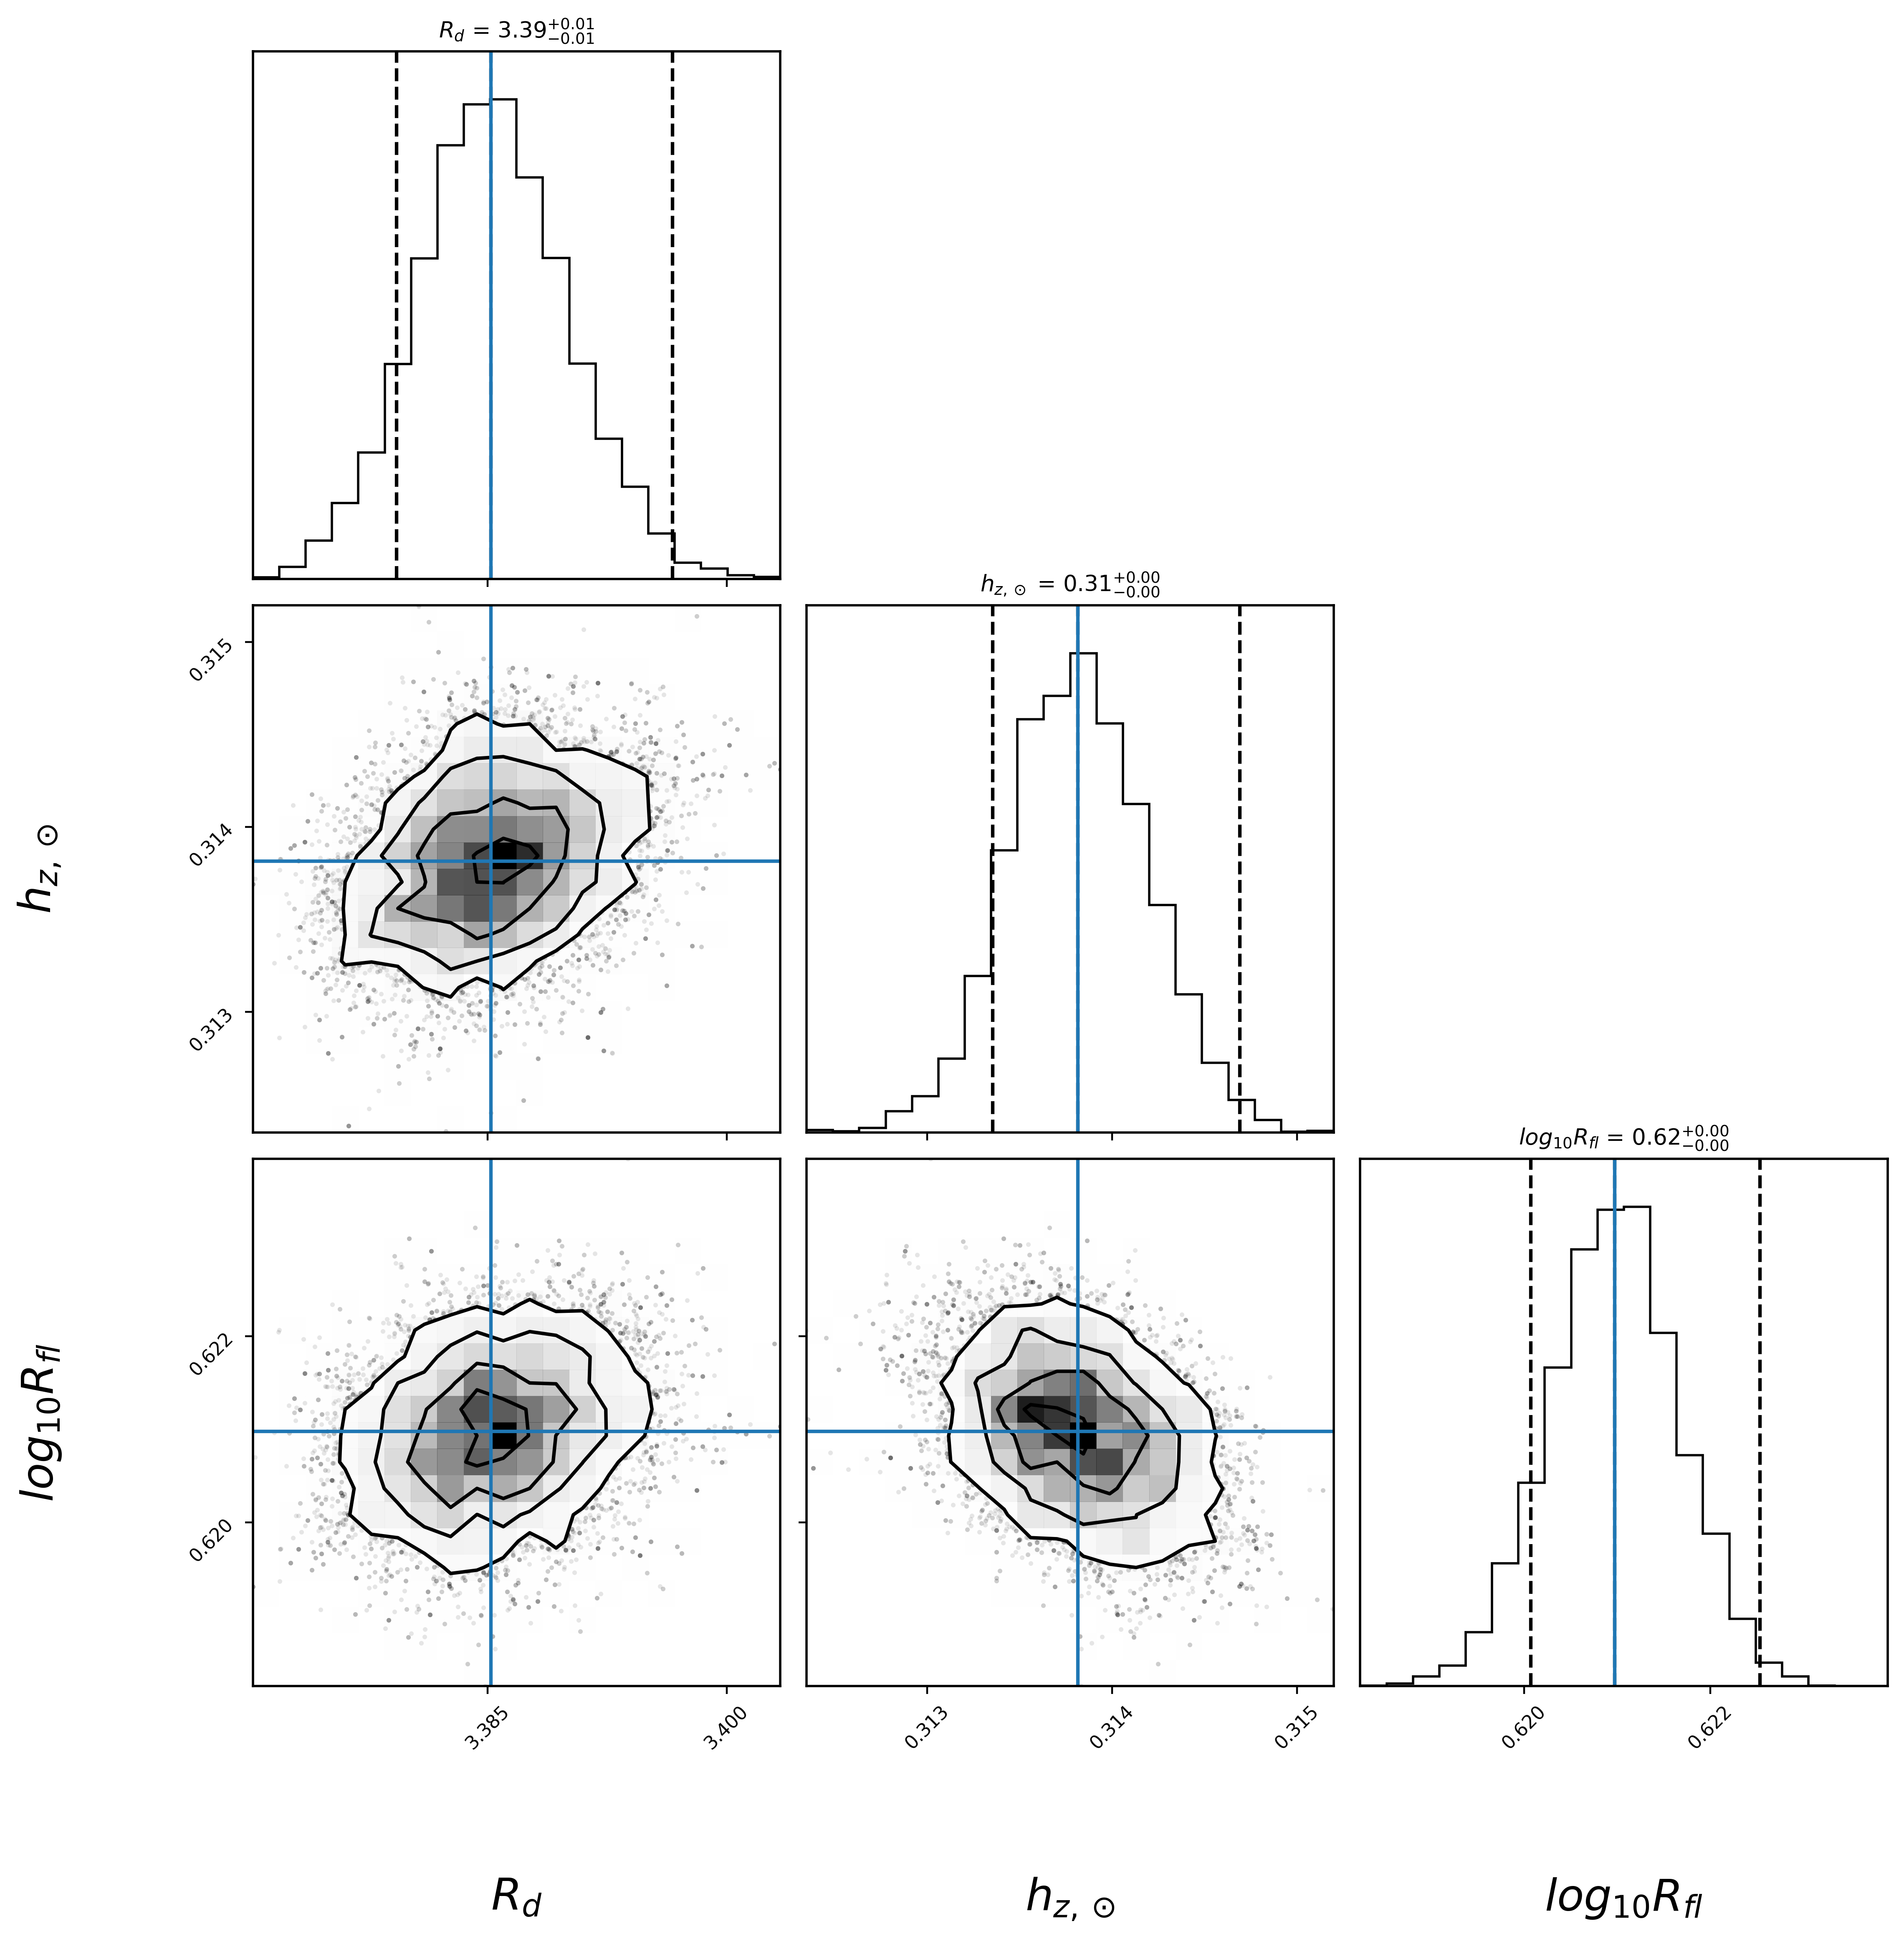

parameters used for best-fit plot...
[3.38520591 0.31381443 0.62097585]


/Users/shouryapro/Documents/pdoc_work/py_scripts/rcdemo/dtools.py:97: RuntimeWarning: invalid value encountered in scalar multiply
  fac1 = (Rd**2.) - (Rd*(Rmax + Rd)*(np.exp(-Rmax/Rd)))
/var/folders/b4/y48vfmk16dnf344d6ld26vtm0000gn/T/ipykernel_5931/1418796765.py:473: RuntimeWarning: invalid value encountered in divide
  im3 = b2.imshow(a3_corr/a1_corr,vmin=-1,vmax=1)#,vmin=-20,vmax=20) # (data-model)/data
/Users/shouryapro/Documents/pdoc_work/py_scripts/rcdemo/dtools.py:451: RuntimeWarning: divide by zero encountered in log
  tmp2 = data*np.log(model)
/var/folders/b4/y48vfmk16dnf344d6ld26vtm0000gn/T/ipykernel_5931/1418796765.py:473: RuntimeWarning: invalid value encountered in divide
  im3 = b2.imshow(a3_corr/a1_corr,vmin=-1,vmax=1)#,vmin=-20,vmax=20) # (data-model)/data
/Users/shouryapro/Documents/pdoc_work/py_scripts/rcdemo/dtools.py:451: RuntimeWarning: divide by zero encountered in log
  tmp2 = data*np.log(model)
/var/folders/b4/y48vfmk16dnf344d6ld26vtm0000gn/T/ipykernel_5931/141

[1, 16, 50, 84, 99]


<Figure size 640x480 with 0 Axes>

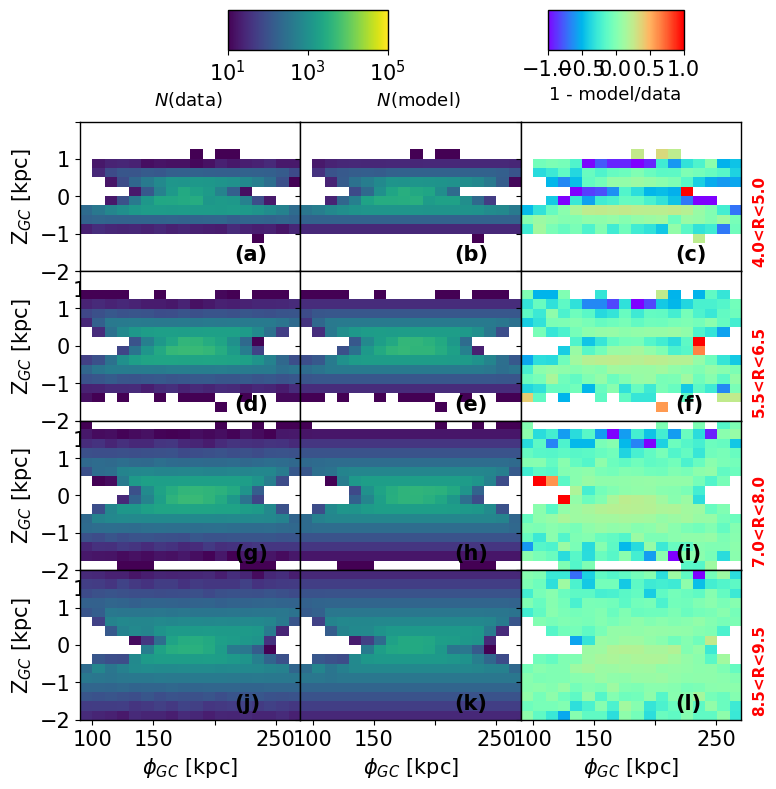

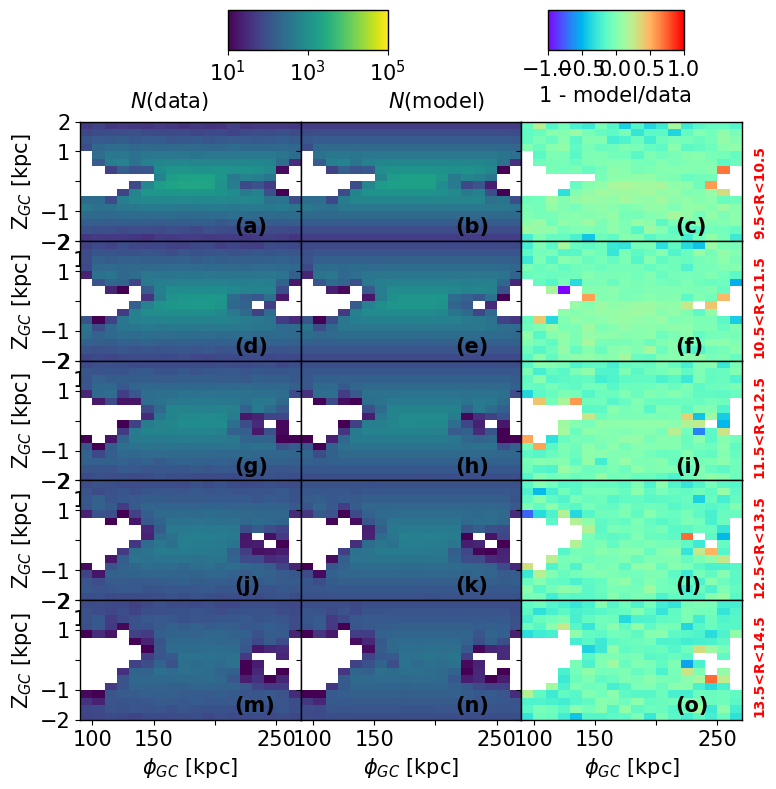

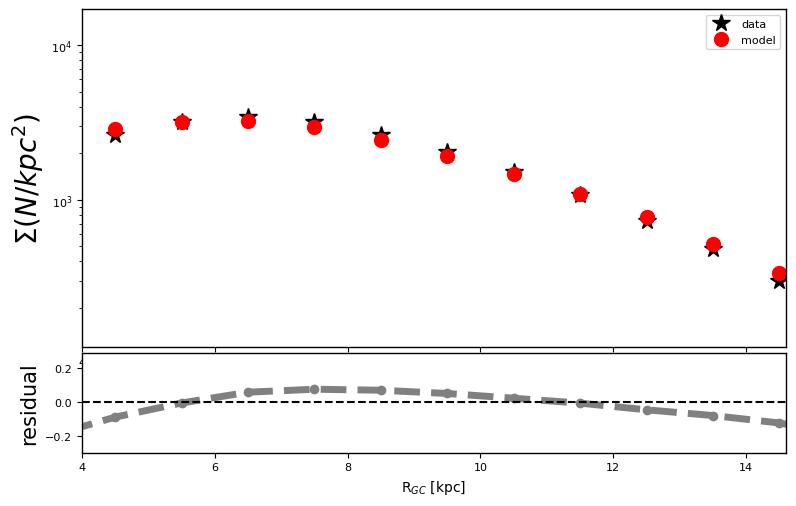

In [23]:
			if plotfit:
                
	
				
				if use_fitres :	
					plt.close('all')
			
					import corner
					bstfitvals = dtools.pickleread(mcmc_res+'/'+suffmcmc+'/result_mcmc_'+suffmcmc+'.pkl')									
					samples =  dtools.pickleread(mcmc_res+'/'+suffmcmc+'/samples_mcmc_'+suffmcmc+'.pkl')
					mclabels =  dtools.pickleread(mcmc_res+'/'+suffmcmc+'/mclabels_'+suffmcmc+'.pkl')
					

					indf = np.where('$h_{z}$' == mclabels)[0]
					mclabels[indf] = param_nam_col['modhz']
					indf = np.where('$hz_{2}$' == mclabels)[0]
					mclabels[indf] = param_nam_col['hz2']
						
					# #bt0mock	labelpad=0.06
					# mcfont = 9						
					# fig1=plt.figure(figsize=(4,4),dpi=400)

					# # #btxmock	labelpad=0.01,
					mcfont = 19					
					fig1=plt.figure(figsize=(12,12),dpi=400)

					# # # #bt1	labelpad=0.01,
					# mcfont = 20						
					# fig1=plt.figure(figsize=(10,10),dpi=400)

					#bt3,4,5,6	labelpad=0.01,
					# mcfont = 16						
					# fig1=plt.figure(figsize=(3.1,3.1),dpi=400)
					
					
					fig = corner.corner(samples,labels=mclabels,show_titles=True,quantiles=[0.1,0.5, 0.99],labelpad=0.06, label_kwargs={"fontsize": mcfont},max_n_ticks=3,fig=fig1)
					corner.overplot_lines(fig,bstfitvals)
					# # # corner.overplot_lines(fig,theta_true,color='red')
		
					# plt.text(0.47,1.5,param_nam_col['phiw']+'='+str(fitparams1_exact['phiw']),transform=plt.gca().transAxes,fontsize=12.5,color='black',rotation=0)	
					# plt.text(0.47,1.3,param_nam_col['aw']+'='+str(fitparams1_exact['aw']),transform=plt.gca().transAxes,fontsize=12.5,color='black',rotation=0)	
					# plt.text(0.47,1.5,param_nam_col['Rw']+'='+str(fitparams1_exact['Rw']),transform=plt.gca().transAxes,fontsize=12.5,color='black',rotation=0)	
					# plt.text(0.47,1.3,param_nam_col['aw']+'='+str(fitparams1_exact['aw']),transform=plt.gca().transAxes,fontsize=12.5,color='black',rotation=0)	
					
					
					plt.show()
					plt.savefig(figdir+'/corner_cylindrical'+suffmcmc+'.png')
					
					
					# corner.overplot_lines(fig,theta_true,color='red')
					# plt.savefig(desktop+'/rubfigs/corner_cylindrical_ovplot.png')
			
					result = {}
					if usefitres_mcmc :				
						result['x'] = bstfitvals.copy()
					if usefitres_opt:
						result['x'] = result_opt['x'].copy()		
					theta_plot = result['x']
				else:
					theta_plot = []				
					for i in range(len(listparams)):					
						theta_plot.append(fitparams1_exact[listparams[i]])
														
				
				# # myfitdata_mle_warp(theta)
				funcargs2 = funcargs1.copy()
				funcargs2['plot_counts'] = True
				funcargs2['inc_projection'] = True
				dtools.picklewrite(funcargs2,'funcargs',tempdir,prnt=False)
				# myfitdata_mle_warp(theta,ncomps=ncomps,plot_counts=True,inc_projection=True,apply_dust=apply_dust,corrsf_=corrsf_)
				print('parameters used for best-fit plot...')
				print(theta_plot)
				myfitdata_mle_warp(theta_plot)
	

